# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
data_2019 = pd.read_csv('Datasets_P3/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('Datasets_P3/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('Datasets_P3/flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investigamos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [10]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [11]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


Corregimos el nombre de fecha2 a fecha

In [12]:
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


Reordenamos el dataset por fecha

In [13]:
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


Graficamos nuestros datos, tal como están

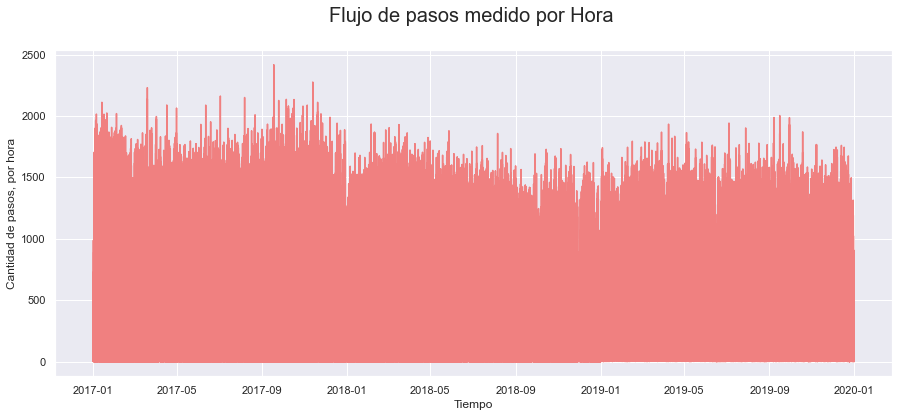

In [14]:
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos,color='lightcoral')
plt.title("Flujo de pasos medido por Hora \n", fontsize= 20)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos, por hora')
plt.show()

Resampleamos nuestros datos para agrupar por dia, para buscar una mejor visualización

In [15]:
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


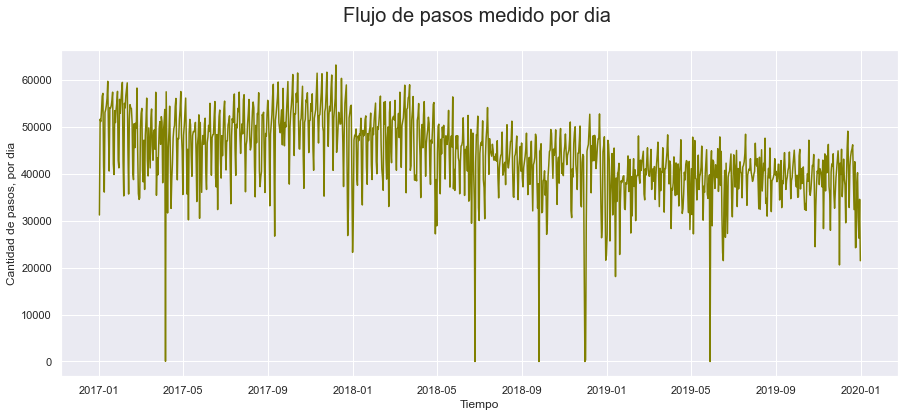

In [16]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos,color='olive')
plt.title("Flujo de pasos medido por dia \n", fontsize= 20)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos, por dia')
plt.show()

### Exploración de los Datos
Inspeccionamos si hay Valores Faltantes

In [17]:
dataset.isnull().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64

In [18]:
dataset_ch=dataset.copy()
dataset_ch['date_check'] = dataset_ch.index.to_series().diff()
dataset_ch.date_check.value_counts()

1.0    238868
Name: date_check, dtype: int64

In [19]:
dataset_ch

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha,date_check
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00,NaN
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00,1.0
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00,1.0
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00,1.0
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00,1.0
...,...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00,1.0
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00,1.0
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00,1.0
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00,1.0


Podemos concluir que no hay Valores Faltantes.

**Estudiamos los Valores Atipicos**

In [20]:
diario_va=diario.copy()
diario_va.describe()

,cantidad_pasos
count,1095.000000
mean,43712.859361
std,8192.736927
min,0.000000
25%,39061.500000
50%,43761.000000
75%,49498.000000
max,63127.000000


In [21]:
diario_va=diario[diario.cantidad_pasos <=10000]
diario_va

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


Observamos la presencia de valores atipicos (en el gráfico lo visualizabamos como unos picos negativos). Esos valores atípicos se deben a fechas en las que no hubo pasos con pagos en efectivo, o que la cantidad de pasos con pago en efectivo estuvieron por debajo de 10000 por día.

In [22]:
diario.cantidad_pasos[diario.cantidad_pasos <=10000] = np.nan

Decidimos reemplazar eso valores atípicos mediante la interpolacion.

La interpolación es el proceso de encontrar un valor entre dos puntos en una línea o una curva. Para ayudarnos a recordar lo que significa, debemos pensar en la primera parte de la palabra, 'inter', como si significara 'ingresar', lo que nos recuerda que debemos mirar 'dentro' de los datos que teníamos originalmente.

In [23]:
print(diario.isna().sum())
diario = diario.interpolate(method='nearest', k=4)
print(diario.isna().sum())

cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


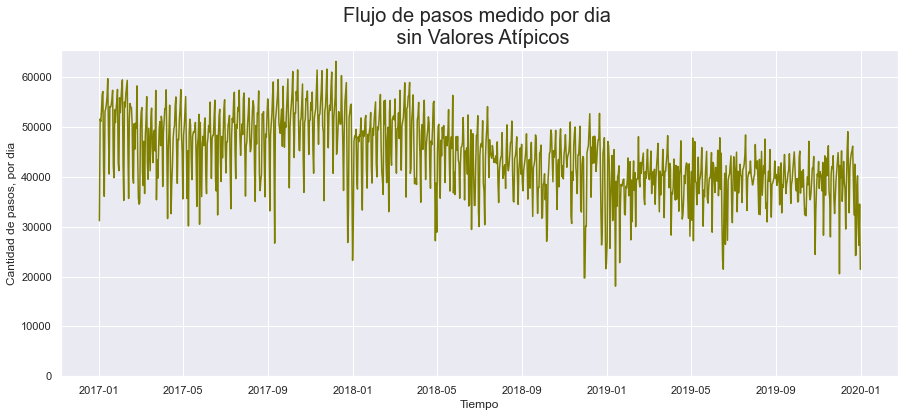

In [24]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos,color='olive')
plt.title("Flujo de pasos medido por dia \n sin Valores Atípicos", fontsize= 20)
plt.xlabel('Tiempo',)
plt.ylabel('Cantidad de pasos, por dia',)
plt.ylim(ymin=0)
plt.show()

Observamos en el gráfico que desaparecen los picos negativos por debajo de 10000 pases diarios, al haber realizado la interpolación. Con este dataset es con el que vamos a trabajar.

**Inspeccionando cuál fue la causa de la presencia de los valores atípicos**

Dado que tenemos exactamente la fecha del valor atípico, inspeccionamos a que se debió: si fue un error de sistema, levantamiento de barreras (ya sea programado por la misma empresa ó en forma de protesta), accidente, obra, etc. Para eso se realizó una exhaustiva búsqueda.

1. El 06/04/2017 se registraron 40 cantidad de pasos con pago en efectivo:

In [25]:
d_2017 =data_2017[(data_2017.estacion=='Illia')& (data_2017.fecha=='2017-04-06')]
d_2017=d_2017.loc[:, ['forma_pago' ,'cantidad_pasos']]
d_2017.groupby('forma_pago').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
forma_pago,
NO COBRADO,45961
TELEPASE,19296
EFECTIVO,40
EXENTO,1


La disminución del cobro en efectivo durante el 06/04/2017, se debio al no cobro de peajes por el [paro nacional](https://www.perfil.com/noticias/sociedad/por-el-paro-no-se-cobrara-peaje-y-habra-libre-estacionamiento-en-calles-y-avenidas.phtml), desde las 6 hasta las 18 hs.

2. El 25/06/2018 se registraron 0 cantidad de pasos con pago en efectivo:

In [26]:
d_2018_25 =data_2018[(data_2018.estacion=='Illia')& (data_2018.fecha=='2018-06-25')]
d_2018_25=d_2018_25.loc[:, ['forma_pago' ,'cantidad_pasos']]
d_2018_25.groupby('forma_pago').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
forma_pago,
NO COBRADO,85099


- La disminución del cobro en efectivo durante el 25/06/2018, se debió al no cobro de pajes por el [paro nacional](https://www.perfil.com/noticias/politica/paro-general-la-ciudad-liberara-peajes-y-estacionamientos.phtml).

3. El 25/09/2018 se registraron 0 cantidad de pasos con pago en efectivo:

In [27]:
d_2018_25_9 =data_2018[(data_2018.estacion=='Illia')& (data_2018.fecha=='2018-09-25')]
d_2018_25_9=d_2018_25_9.loc[:, ['forma_pago' ,'cantidad_pasos']]
d_2018_25_9.groupby('forma_pago').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
forma_pago,
NO COBRADO,78690


- La disminución del cobro en efectivo durante el 25/09/2018, se debió al no cobro de pajes por el [paro nacional](https://www.lanacion.com.ar/politica/paro-general-del-25-septiembre-que-gremios-nid2174190/).

4. El 30/11/2018 se registraron 0 cantidad de pasos con pago en efectivo:

In [28]:
d_2018_30 =data_2018[(data_2018.estacion=='Illia')& (data_2018.fecha=='2018-11-30')]
d_2018_30=d_2018_30.loc[:, ['forma_pago' ,'cantidad_pasos']]
d_2018_30.groupby('forma_pago').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
forma_pago,
NO COBRADO,387


5. El 01/12/2018 se registraron 350 cantidad de pasos con pago en efectivo:

In [29]:
d_2018_1 =data_2018[(data_2018.estacion=='Illia')& (data_2018.fecha=='2018-12-01')]
d_2018_1=d_2018_1.loc[:, ['forma_pago' ,'cantidad_pasos']]
d_2018_1.groupby('forma_pago').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
forma_pago,
NO COBRADO,464
EFECTIVO,350
TELEPASE,290
EXENTO,9
INFRACCION,5
TARJETA DISCAPACIDAD,3


- La disminución de los cobros, y en general de los pases con pago en efectivo durante 30/11/2018 y 01/12/2018, se debió a los cortes y operativos de seguridad por [G20](https://www.baenegocios.com/politica/Cortes-y-operativo-de-seguridad-por-el-G20--20181114-0016.html).

6. El 29/05/2019 se registraron 0 cantidad de pasos con pago en efectivo:

In [30]:
d_2019_29 =data_2019[(data_2019.estacion=='Illia')& (data_2019.fecha=='2019-05-29')]
d_2019_29=d_2019_29.loc[:, ['forma_pago' ,'cantidad_pasos']]
d_2019_29.groupby('forma_pago').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
forma_pago,
NO COBRADO,87419


- La disminucion del cobro en efectivo durante el 29/05/2019, se debó al no cobro de pajes por el [paro nacional](https://www.telam.com.ar/notas/201905/362277-por-el-paro-los-peajes-son-gratuitos-y-el-estacionamiento-es-libre-en-la-ciudad-de-buenos-aires.html).

**Estudiando el comportamiento de la cantidad de pasos con forma de pago No Cobrado**

Unimos los 3 datasets (podemos hacerlo así ya que tienen las mismas columnas), nos quedamos con la estación Illia y la forma de pago Efectivo y quitamos las columnas que no vamos a utilizar.

In [31]:
dataset_nc = pd.concat([data_2019, data_2018, data_2017])

mask_1 = np.logical_and(dataset_nc.estacion=='Illia', dataset_nc.forma_pago == 'NO COBRADO')
dataset_nc = dataset_nc[mask_1]

dataset_nc.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset_nc.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
19,2019-01-01,1,Martes,Centro,Liviano,146
22,2019-01-01,1,Martes,Provincia,Liviano,147
24,2019-01-01,1,Martes,Provincia,Pesado,3
83,2019-01-01,2,Martes,Centro,Liviano,8
91,2019-01-01,2,Martes,Provincia,Liviano,4


Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora. También, quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2

In [32]:
dataset_nc['fecha2'] = pd.to_datetime(dataset_nc.fecha) + pd.to_timedelta(dataset_nc.hora_fin, unit = 'h')

dataset_nc.drop(columns=['fecha','hora_fin'], inplace = True)

dataset_nc.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
19,Martes,Centro,Liviano,146,2019-01-01 01:00:00
22,Martes,Provincia,Liviano,147,2019-01-01 01:00:00
24,Martes,Provincia,Pesado,3,2019-01-01 01:00:00
83,Martes,Centro,Liviano,8,2019-01-01 02:00:00
91,Martes,Provincia,Liviano,4,2019-01-01 02:00:00


Corregimos el nombre de fecha2 a fecha

In [33]:
dataset_nc.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset_nc.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
19,Martes,Centro,Liviano,146,2019-01-01 01:00:00
22,Martes,Provincia,Liviano,147,2019-01-01 01:00:00
24,Martes,Provincia,Pesado,3,2019-01-01 01:00:00
83,Martes,Centro,Liviano,8,2019-01-01 02:00:00
91,Martes,Provincia,Liviano,4,2019-01-01 02:00:00


Reordenamos el dataset_nc por fecha

In [34]:
dataset_nc.sort_values('fecha', inplace = True)
dataset_nc.reset_index(drop=True, inplace = True)
dataset_nc

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Liviano,3,2017-01-01 00:00:00
1,Domingo,Centro,Liviano,183,2017-01-01 00:00:00
2,Domingo,Centro,Liviano,252,2017-01-01 01:00:00
3,Domingo,Provincia,Liviano,157,2017-01-01 01:00:00
4,Domingo,Provincia,Liviano,35,2017-01-01 02:00:00
...,...,...,...,...,...
66674,Martes,Provincia,Liviano,24,2019-12-31 21:00:00
66675,Martes,Centro,Liviano,11,2019-12-31 22:00:00
66676,Martes,Provincia,Liviano,27,2019-12-31 22:00:00
66677,Martes,Provincia,Liviano,7,2019-12-31 23:00:00


Resampleamos nuestros datos para agrupar por dia, y buscar una visualización más amigable

In [35]:
diario_nc = dataset_nc.resample('D', on = 'fecha').sum()
print(diario_nc.shape)
diario_nc.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,1306
2017-01-02,627
2017-01-03,538
2017-01-04,618
2017-01-05,604


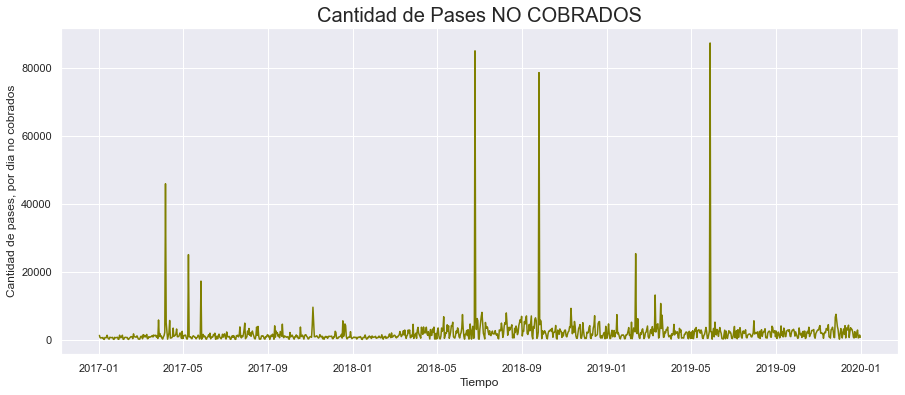

In [36]:
plt.figure(figsize = (15,6))
plt.plot(diario_nc.index, diario_nc.cantidad_pasos,color='olive')
plt.title("Cantidad de Pases NO COBRADOS", fontsize= 20)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pases, por dia no cobrados',)
plt.show()

*Podemos concluir que los dias que se producen los picos negativos de los cobros en Efectivo, se producen picos positivos de los No Cobrados*
### Dias y horarios de Mayor Tráfico
1. ¿Cuál fué la fecha con más pases?

In [37]:
masc_1= diario[diario.cantidad_pasos>=(diario.cantidad_pasos.mean()+ diario.cantidad_pasos.std())]
masc_1.sort_values('cantidad_pasos',ascending=False)

,cantidad_pasos
fecha,
2017-12-07,63127.0
2017-11-24,61594.0
2017-10-13,61421.0
2017-11-10,61382.0
2017-11-17,61259.0
...,...
2017-09-19,51556.0
2018-01-18,51548.0
2017-02-13,51546.0


*La fecha que mayor cantidad de pasos fue el 07/12/2017, de los tres años.*

2. ¿Cuál fué el sentido con más pases?

In [38]:
masc_2= dataset[dataset.cantidad_pasos>=(dataset.cantidad_pasos.mean()+ dataset.cantidad_pasos.std())]
masc_2

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
11,Domingo,Centro,Liviano,857,2017-01-01 00:00:00
16,Domingo,Centro,Liviano,783,2017-01-01 02:00:00
19,Domingo,Provincia,Liviano,704,2017-01-01 03:00:00
22,Domingo,Centro,Liviano,988,2017-01-01 03:00:00
...,...,...,...,...,...
238850,Martes,Provincia,Liviano,643,2019-12-31 18:00:00
238854,Martes,Provincia,Liviano,640,2019-12-31 19:00:00
238858,Martes,Provincia,Liviano,773,2019-12-31 20:00:00
238861,Martes,Provincia,Liviano,905,2019-12-31 21:00:00


In [39]:
masc_2.groupby('sentido').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
sentido,
Centro,19650277
Provincia,18327981


*Según la cantidad de pasos, los autos se dirigieron más en sentido al centro.*

3. ¿Cuál fué la hora y de que fecha con más pases?

In [40]:
masc_2.groupby('fecha').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
fecha,
2017-10-05 18:00:00,3842
2017-10-13 15:00:00,3794
2017-11-17 14:00:00,3738
2017-12-07 16:00:00,3726
2017-10-13 16:00:00,3629
...,...
2019-10-24 23:00:00,604
2018-03-10 00:00:00,604
2018-02-12 09:00:00,604


*La hora con mas pases fue a las 18 hs del 05/10/2017.*

4. ¿Cuál fué el día de la semana con más pases?

In [41]:
masc_2.groupby('dia').sum().sort_values('cantidad_pasos', ascending=False)

,cantidad_pasos
dia,
Viernes,6260472
Jueves,5892907
Miércoles,5674526
Martes,5442516
Lunes,5225756
Sábado,5182949
Domingo,4299132


*El día de la semana con mas pases fué el viernes.*
### Estudiando cada año
**Año 2017**

In [42]:
da_2017 =data_2017[data_2017.estacion=='Illia']
da_2017.describe(include='all')

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
count,291900.0,291900,291900.000000,291900.000000,291900,291900,291900,291900,291900,291900.000000
unique,NaN,365,NaN,NaN,7,1,2,2,7,NaN
top,NaN,2017-01-30,NaN,NaN,Viernes,Illia,Centro,Pesado,EFECTIVO,NaN
freq,NaN,906,NaN,NaN,43944,291900,160328,161166,104230,NaN
mean,2017.0,NaN,11.951011,12.080877,NaN,NaN,NaN,NaN,NaN,115.007139
std,0.0,NaN,6.535413,6.603749,NaN,NaN,NaN,NaN,NaN,347.277410
min,2017.0,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000
25%,2017.0,NaN,7.000000,7.000000,NaN,NaN,NaN,NaN,NaN,2.000000
50%,2017.0,NaN,12.000000,12.000000,NaN,NaN,NaN,NaN,NaN,6.000000
75%,2017.0,NaN,17.000000,18.000000,NaN,NaN,NaN,NaN,NaN,23.000000


In [43]:
da_2017['forma_pago'].value_counts()

EFECTIVO                104230
TELEPASE                 79903
EXENTO                   39201
INFRACCION               24526
TARJETA DISCAPACIDAD     22145
NO COBRADO               21881
MONEDERO                    14
Name: forma_pago, dtype: int64

In [44]:
data_2017['forma_pago'].value_counts()

EFECTIVO                447203
TELEPASE                397420
EXENTO                  169889
INFRACCION              140275
NO COBRADO              117730
TARJETA DISCAPACIDAD    100106
MONEDERO                    14
Otros                        8
Name: forma_pago, dtype: int64


**Año 2017**

  - De todas las estaciones de peaje, la forma de pago elegida: Efectivo

  - Estacion Illia en particular

           - Fecha con más cantidad de pasos: 30/01/2017
           - Día de la semana con más cantidad de pasos: Viernes
           - Sentido con más pasos: Centro
           - Tipo de veháculo que más paso: Pesado
           - Forma de pago con más pasos: Efectivo
        
**Año 2018** 

In [45]:
da_2018 =data_2018[data_2018.estacion=='Illia']
da_2018.describe(include='all')

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
count,299519.0,299519,299519.000000,299519.000000,299519,299519,299519,299519,299519,299519.000000
unique,NaN,365,NaN,NaN,7,1,2,2,6,NaN
top,NaN,2018-10-05,NaN,NaN,Miércoles,Illia,Centro,Pesado,EFECTIVO,NaN
freq,NaN,960,NaN,NaN,45522,299519,154648,163619,99996,NaN
mean,2018.0,NaN,11.932589,12.045807,NaN,NaN,NaN,NaN,NaN,115.151419
std,0.0,NaN,6.552504,6.618378,NaN,NaN,NaN,NaN,NaN,354.717350
min,2018.0,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000
25%,2018.0,NaN,7.000000,7.000000,NaN,NaN,NaN,NaN,NaN,2.000000
50%,2018.0,NaN,12.000000,12.000000,NaN,NaN,NaN,NaN,NaN,5.000000
75%,2018.0,NaN,17.000000,18.000000,NaN,NaN,NaN,NaN,NaN,20.000000


In [46]:
da_2018['forma_pago'].value_counts()

EFECTIVO                99996
TELEPASE                89921
EXENTO                  37498
INFRACCION              29459
NO COBRADO              23454
TARJETA DISCAPACIDAD    19191
Name: forma_pago, dtype: int64

In [47]:
data_2018['forma_pago'].value_counts()

TELEPASE                429053
EFECTIVO                423633
EXENTO                  162103
INFRACCION              153331
NO COBRADO              121440
TARJETA DISCAPACIDAD     86348
Name: forma_pago, dtype: int64

**Año 2018**

   - De todas las estaciones de peaje, la forma de pago elegida: telepase
   - Estacion Illia en particular

         - Fecha con más cantidad de pasos: 05/10/2018
         - Día de la semana con más cantidad de pasos: Miércoles
         - Sentido con más pasos: Centro
         - Tipo de vehículo que más paso: Pesado
         - Forma de pago con más pasos: Efectivo
        
**Año 2019**

In [48]:
da_2019 =data_2019[data_2019.estacion=='Illia']
da_2019.describe(include='all')

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
count,161133.0,161133,161133.000000,161133.000000,161133,161133,161133,161133,161133,161133.000000
unique,NaN,365,NaN,NaN,7,1,2,2,6,NaN
top,NaN,2019-03-15,NaN,NaN,Martes,Illia,Provincia,Liviano,TELEPASE,NaN
freq,NaN,480,NaN,NaN,23602,161133,81283,100861,34788,NaN
mean,2019.0,NaN,11.770004,11.827180,NaN,NaN,NaN,NaN,NaN,211.968790
std,0.0,NaN,6.718099,6.759874,NaN,NaN,NaN,NaN,NaN,488.961921
min,2019.0,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000
25%,2019.0,NaN,6.000000,6.000000,NaN,NaN,NaN,NaN,NaN,4.000000
50%,2019.0,NaN,12.000000,12.000000,NaN,NaN,NaN,NaN,NaN,12.000000
75%,2019.0,NaN,17.000000,18.000000,NaN,NaN,NaN,NaN,NaN,68.000000


In [49]:
da_2019['forma_pago'].value_counts()

TELEPASE           34788
EFECTIVO           34643
EXENTO             29204
INFRACCION         24015
NO COBRADO         21344
T. DISCAPACIDAD    17139
Name: forma_pago, dtype: int64

In [50]:
data_2019['forma_pago'].value_counts()

TELEPASE           201388
EFECTIVO           149340
NO COBRADO         141280
EXENTO             132716
INFRACCION         111428
T. DISCAPACIDAD     76001
Name: forma_pago, dtype: int64

**Año 2019**
   - De todas las estaciones de peaje, la forma de pago elegida: telepase
   - Estación Illia en particular
        - Fecha con mas cantidad de pasos: 15/03/2019
        - Día de la semana con mas cantidad de pasos : Martes
        - Sentido con mas pasos : Provincia
        - Tipo de vehiculo que mas paso : liviano
        - Forma de pago con mas pasos: Telepase
        
### Analizando las formas de pago: Efectivo y Telepase

1. En la Autopista Illia

Creando el dataset de telepases (Unimos los 3 datasets)

In [51]:
dataset_t = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask_t_i = np.logical_and(dataset_t.estacion=='Illia', dataset_t.forma_pago == 'TELEPASE')
dataset_t = dataset_t[mask_t_i]
#Quitamos las columnas que no vamos a utilizar
dataset_t.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_t['fecha2'] = pd.to_datetime(dataset_t.fecha) + pd.to_timedelta(dataset_t.hora_fin, unit = 'h')
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_t.drop(columns=['fecha','hora_fin'], inplace = True)
#Corregimos el nombre de fecha2 a fecha
dataset_t.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#Reordenamos el dataset_t por fecha
dataset_t.sort_values('fecha', inplace = True)
dataset_t.reset_index(drop=True, inplace = True)
#Resampleamos nuestros datos para agrupar por dia, y asi buscar una mejor visualización
diario_t = dataset_t.resample('D', on = 'fecha').sum()

In [52]:
print("Año-2017")
print("Porcentaje de pago en Efectivo  sobre el total de pagos: ", "{0:.0%}".format
      (da_2017[da_2017.forma_pago=='EFECTIVO'].shape[0]/da_2017["forma_pago"].shape[0]))
print("Porcentaje de pago Con Telepase sobre el total de pagos: ", "{0:.0%}".format
      (da_2017[da_2017.forma_pago=='TELEPASE'].shape[0]/da_2017["forma_pago"].shape[0]))

Año-2017
Porcentaje de pago en Efectivo  sobre el total de pagos:  36%
Porcentaje de pago Con Telepase sobre el total de pagos:  27%


In [53]:
print("Año-2018")
print("Porcentaje de pago en Efectivo  sobre el total de pagos: ", "{0:.0%}".format
      (da_2018[da_2018.forma_pago=='EFECTIVO'].shape[0]/da_2018["forma_pago"].shape[0]))
print("Porcentaje de pago Con Telepase sobre el total de pagos: ", "{0:.0%}".format
      (da_2018[da_2018.forma_pago=='TELEPASE'].shape[0]/da_2018["forma_pago"].shape[0]))

Año-2018
Porcentaje de pago en Efectivo  sobre el total de pagos:  33%
Porcentaje de pago Con Telepase sobre el total de pagos:  30%


In [54]:
print("Año-2019")
print("Porcentaje de pago en Efectivo  sobre el total de pagos: ", "{0:.0%}".format
      (da_2019[da_2019.forma_pago=='EFECTIVO'].shape[0]/da_2019["forma_pago"].shape[0]))
print("Porcentaje de pago Con Telepase sobre el total de pagos: ", "{0:.0%}".format
      (da_2019[da_2019.forma_pago=='TELEPASE'].shape[0]/da_2019["forma_pago"].shape[0]))

Año-2019
Porcentaje de pago en Efectivo  sobre el total de pagos:  21%
Porcentaje de pago Con Telepase sobre el total de pagos:  22%


*Podemos determinar, con estos porcentajes, que en la autopista Illia hay una migracion de la forma de pago de desde Efectivo a Telepase. Esto se debio fundamentalmente a la Inauguracion del [Paseo del Bajo](https://www.perfil.com/noticias/sociedad/macri-vidal-y-larreta-inauguran-hoy-el-monumental-paseo-del-bajo.phtml) y a las polïticas de CABA implementadas de [Tarifas Planas](https://www.ausa.com.ar/novedades/atencion-camiones-para-ingresar-al-paseo-del-bajo-es-necesario-contar-con-telepase/), para incentivar el pago con telepase.*

A los fines de poder visualizar la tendencia se hizo un resampleo a la forma mensual

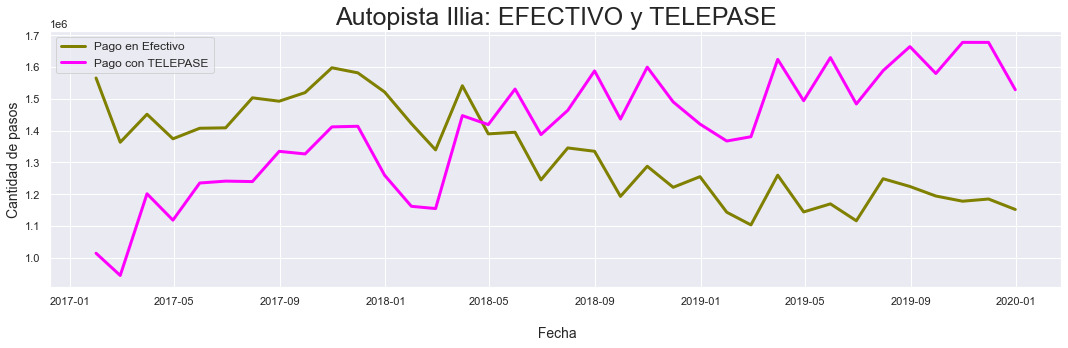

In [55]:
mensual_t =dataset_t.resample('M', on = 'fecha').sum()
mensual =dataset.resample('M', on = 'fecha').sum()

plt.figure(figsize=(15,5))
plt.plot(mensual.index, mensual.cantidad_pasos,lw=3,color='olive', label='Pago en Efectivo')
plt.plot(mensual_t.index, mensual_t.cantidad_pasos, lw=3, color='magenta',label='Pago con TELEPASE')
plt.title ('Autopista Illia: EFECTIVO y TELEPASE', fontsize=25)
plt.xlabel('\n Fecha',fontsize=14)
plt.ylabel('Cantidad de pasos',fontsize=14)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

*Claramente observamos que la cantidad de pasos con pago en efectivo fue decreciendo en el Intervalo de los 3 años , o sea hubo una migracion a la forma de pago Telepase. Esto tambien tiene relacion con los descuentos que se ofrecía si los usuarios elegian esta forma de pago. A partir del 28/09/2020 ya es obligatorio el uso de [Telepase](https://www.buenosaires.gob.ar/jefaturadegabinete/movilidad/noticias/por-el-alto-numero-de-adhesiones-diarias-habra-tiempo-hasta-el), siendo el descuento a la fecha de un 30%.*

2. Comparamos Estacion Illia con Avellaneda: las dos formas de pago

In [56]:
#Unimos los 3 datasets
dataset_a = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask_a = np.logical_and(dataset_a.estacion=='Avellaneda', dataset_a.forma_pago == 'EFECTIVO')
dataset_a = dataset_a[mask_a]
#Quitamos las columnas que no vamos a utilizar
dataset_a.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_a['fecha2'] = pd.to_datetime(dataset_a.fecha) + pd.to_timedelta(dataset_a.hora_fin, unit = 'h')
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_a.drop(columns=['fecha','hora_fin'], inplace = True)
#Corregimos el nombre de fecha2 a fecha
dataset_a.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#Reordenamos el dataset_a por fecha
dataset_a.sort_values('fecha', inplace = True)
dataset_a.reset_index(drop=True, inplace = True)
#Resampleamos nuestros datos para agrupar por dia, y asi buscar una mejor visualización
diario_a = dataset_a.resample('D', on = 'fecha').sum()
diario_a.head()

,cantidad_pasos
fecha,
2017-01-01,72504
2017-01-02,87547
2017-01-03,86139
2017-01-04,88180
2017-01-05,90281


In [57]:
#Unimos los 3 datasets
dataset_a_t = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask_a_t = np.logical_and(dataset_a_t.estacion=='Avellaneda', dataset_a_t.forma_pago == 'TELEPASE')
dataset_a_t = dataset_a_t[mask_a_t]
#Quitamos las columnas que no vamos a utilizar
dataset_a_t.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset_a_t['fecha2'] = pd.to_datetime(dataset_a_t.fecha) + pd.to_timedelta(dataset_a_t.hora_fin, unit = 'h')
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset_a_t.drop(columns=['fecha','hora_fin'], inplace = True)
#Corregimos el nombre de fecha2 a fecha
dataset_a_t.rename(columns = {'fecha2':'fecha'}, inplace = True) 
#Reordenamos el dataset_a_t por fecha
dataset_a_t.sort_values('fecha', inplace = True)
dataset_a_t.reset_index(drop=True, inplace = True)
#Resampleamos nuestros datos para agrupar por dia, y asi buscar una mejor visualización
diario_a_t = dataset_a_t.resample('D', on = 'fecha').sum()
diario_a_t.head()

,cantidad_pasos
fecha,
2017-01-01,22024
2017-01-02,43988
2017-01-03,46780
2017-01-04,46623
2017-01-05,48311


Para vizuaizar la tendencia se hizo un resampleo a la forma mensual:

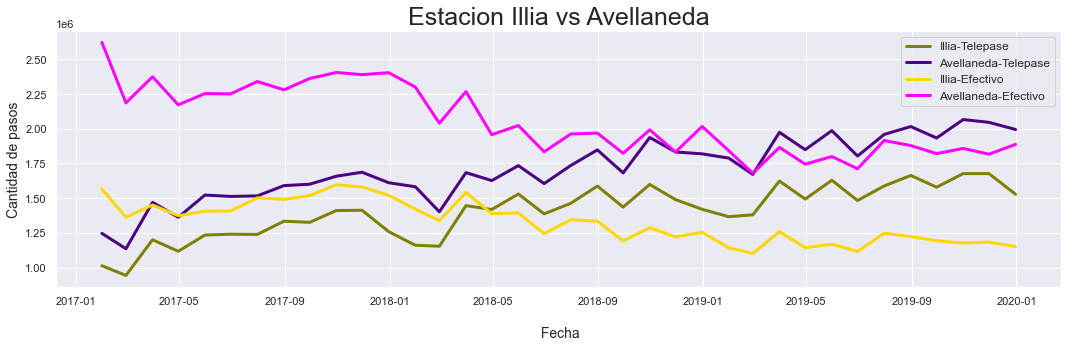

In [58]:
mensual_t =dataset_t.resample('M', on = 'fecha').sum()
mensual_a =dataset_a.resample('M', on = 'fecha').sum()
mensual_a_t =dataset_a_t.resample('M', on = 'fecha').sum()
mensual =dataset.resample('M', on = 'fecha').sum()

plt.figure(figsize=(15,5))
plt.plot(mensual_t.index, mensual_t.cantidad_pasos,lw=3,color='olive', label='Illia-Telepase')
plt.plot(mensual_a_t.index, mensual_a_t.cantidad_pasos, lw=3, color='indigo',label='Avellaneda-Telepase')
plt.plot(mensual.index, mensual.cantidad_pasos,lw=3,color='gold', label='Illia-Efectivo')
plt.plot(mensual_a.index, mensual_a.cantidad_pasos, lw=3, color='magenta',label='Avellaneda-Efectivo')


plt.title ('Estacion Illia vs Avellaneda', fontsize=25)
plt.xlabel('\n Fecha',fontsize=14)
plt.ylabel('Cantidad de pasos',fontsize=14)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

*Claramente observamos que en las ods estaciones de Peaje, la cantidad de pasos con pago en efectivo fue decreciendo en el Intervalo de los 3 años, es decir, hubo una migración a la forma de pago Telepase.*
### Resampleos
**Probaremos diferentes formas de resampleos, para luego decidir con cual de todos trabajar.**

A. Resampleamos con la suma

1. Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable, con el data diarios donde ya realizamos la interpolacion de los datos atipicos

In [59]:
semanal =diario.resample('W').sum()
print(semanal.shape)
semanal

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-08,347212.0
2017-01-15,366413.0
2017-01-22,357215.0
2017-01-29,354581.0
...,...
2019-12-08,282891.0
2019-12-15,272960.0
2019-12-22,292881.0


2. Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable, con el dataset original

In [60]:
semanal_1 =dataset.resample('W', on = 'fecha').sum()
print(semanal_1.shape)
semanal_1

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581
...,...
2019-12-08,282891
2019-12-15,272960
2019-12-22,292881


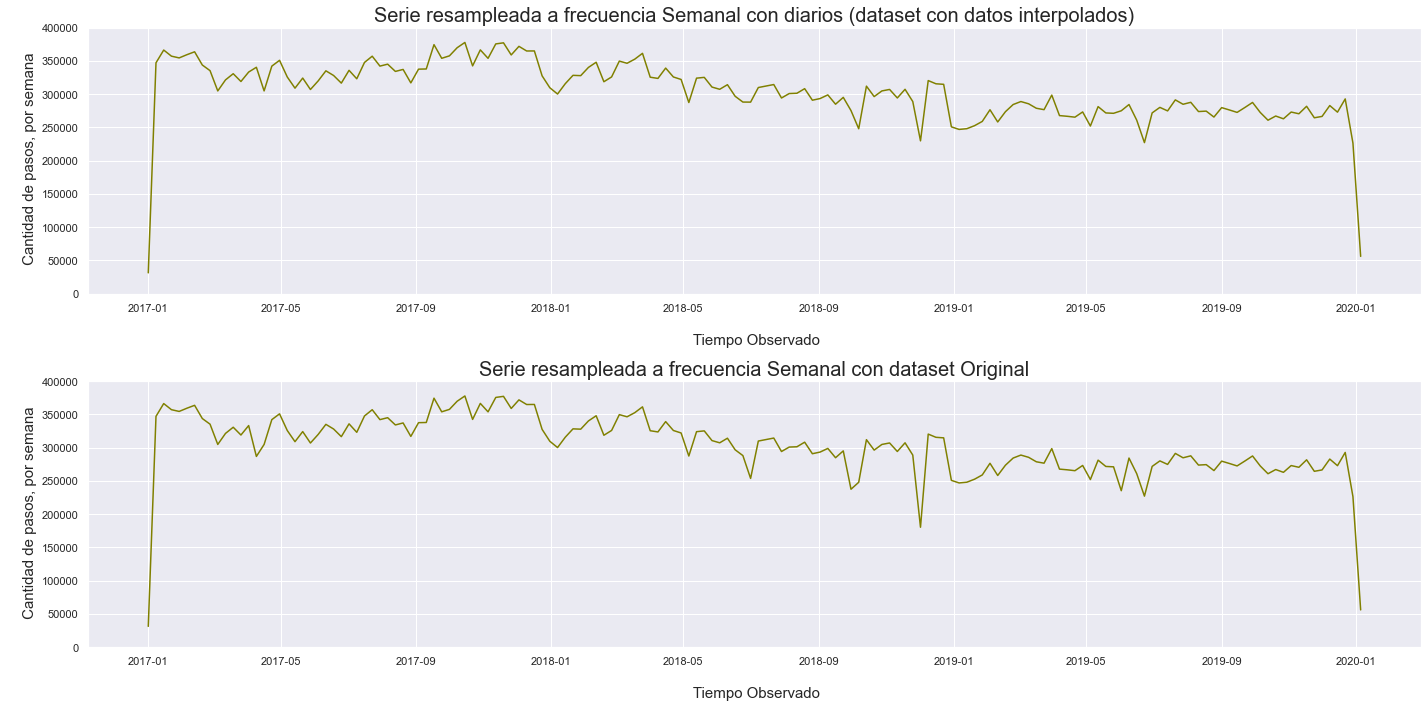

In [61]:
plt.figure(figsize = (20,10))
Gs= gridspec.GridSpec(2,1)
ax0= plt.subplot(Gs[0])
plt.plot(semanal.index, semanal.cantidad_pasos,color='olive')
plt.title("Serie resampleada a frecuencia Semanal con diarios (dataset con datos interpolados)", fontsize= 20)
plt.xlabel('\n Tiempo Observado', fontsize= 15)
plt.ylabel('\n Cantidad de pasos, por semana', fontsize= 15)
plt.ylim(0,400000)
ax1= plt.subplot(Gs[1])
plt.plot(semanal_1.index, semanal_1.cantidad_pasos,color='olive')
plt.title("Serie resampleada a frecuencia Semanal con dataset Original", fontsize= 20)
plt.xlabel('\n Tiempo Observado', fontsize= 15)
plt.ylabel('\n Cantidad de pasos, por semana', fontsize= 15)
plt.ylim(0,400000)
plt.tight_layout()
plt.show()

Observamos la diferencia que hay en los gráficos anteriores al trabajar con la series interpoladas y con la serie original, por ejemplo los picos negativos que están en el segundo grafico, son más aprovechables en el primer gráfico.

*Graficamos la Serie Temporal Diaria y la Serie Semanal resamplada con la SUMA*

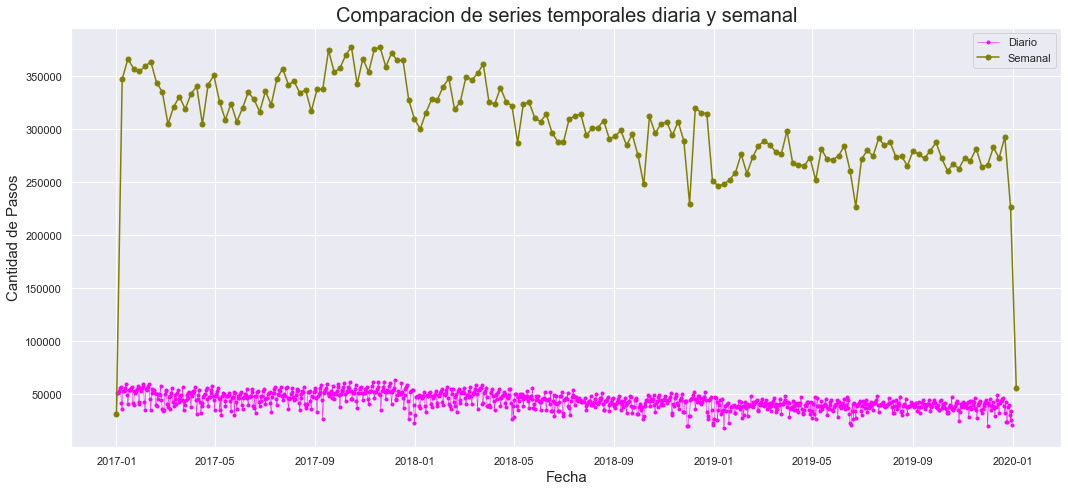

In [62]:
fig,eje = plt.subplots(figsize = (15,7))
eje.plot(diario,marker='.',linestyle='-',linewidth=0.5,label='Diario', color='magenta')
eje.plot(semanal,marker='o',markersize=5,label='Semanal', color='olive')
eje.set_ylabel('Cantidad de Pasos', fontsize= 15 )
eje.set_xlabel('Fecha', fontsize= 15 )
eje.legend()
plt.title("Comparacion de series temporales diaria y semanal", fontsize= 20)
plt.tight_layout()
plt.show()

B. Resampleamos con la media

1. Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización más amigable, con el data diarios donde ya realizamos la interpolacion de los datos atipicos.

In [63]:
semanal_m =diario.resample('W').mean()
print(semanal_m.shape)
semanal_m

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183.000000
2017-01-08,49601.714286
2017-01-15,52344.714286
2017-01-22,51030.714286
2017-01-29,50654.428571
...,...
2019-12-08,40413.000000
2019-12-15,38994.285714
2019-12-22,41840.142857


2. Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable, con el dataset original.

In [64]:
diario_1 = dataset.resample('D', on = 'fecha').sum()
semanal_1_m =diario_1.resample('W').mean()
print(semanal_1_m.shape)
semanal_1_m

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183.000000
2017-01-08,49601.714286
2017-01-15,52344.714286
2017-01-22,51030.714286
2017-01-29,50654.428571
...,...
2019-12-08,40413.000000
2019-12-15,38994.285714
2019-12-22,41840.142857


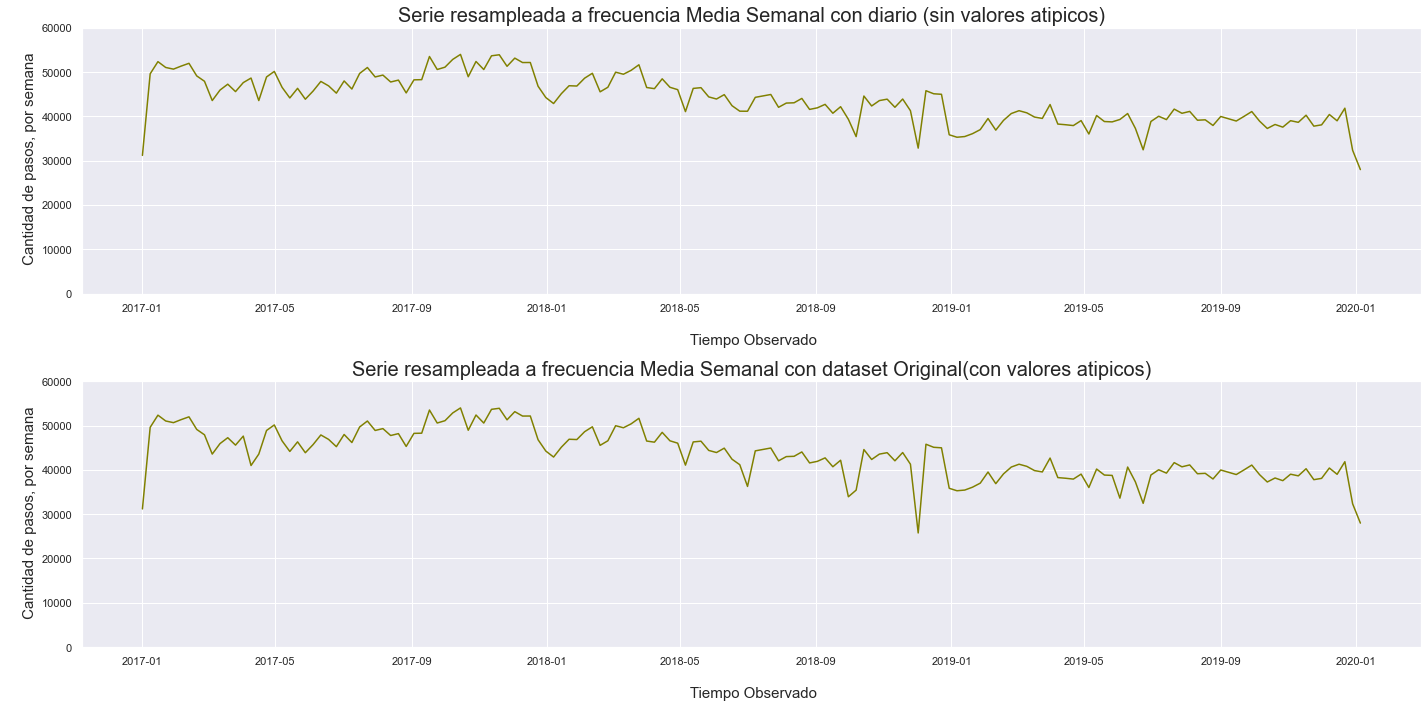

In [65]:
plt.figure(figsize = (20,10))
Gs= gridspec.GridSpec(2,1)
ax0= plt.subplot(Gs[0])
plt.plot(semanal.index, semanal_m.cantidad_pasos,color='olive')
plt.title("Serie resampleada a frecuencia Media Semanal con diario (sin valores atipicos)", fontsize= 20)
plt.xlabel('\n Tiempo Observado', fontsize= 15)
plt.ylabel('\n Cantidad de pasos, por semana', fontsize= 15)
plt.ylim(0,60000)
ax1= plt.subplot(Gs[1])
plt.plot(semanal_1.index, semanal_1_m.cantidad_pasos,color='olive')
plt.title("Serie resampleada a frecuencia Media Semanal con dataset Original(con valores atipicos)", fontsize= 20)
plt.xlabel('\n Tiempo Observado', fontsize= 15)
plt.ylabel('\n Cantidad de pasos, por semana', fontsize= 15)
plt.ylim(0,60000)
plt.tight_layout()
plt.show()

*Graficamos la Serie Temporal Diaria y la Serie Media Semanal resamplada con la Media*

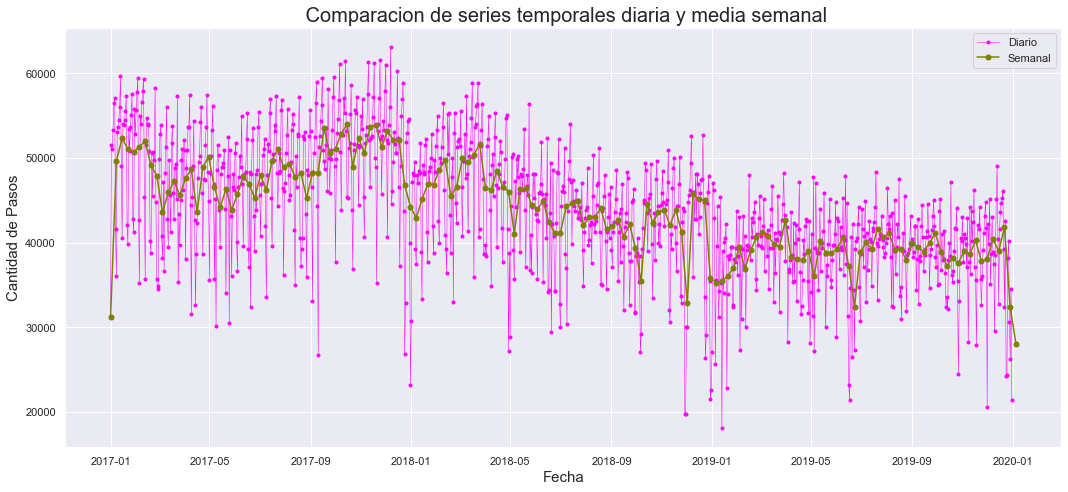

In [66]:
fig,eje = plt.subplots(figsize = (15,7))
eje.plot(diario,marker='.',linestyle='-',linewidth=0.5,label='Diario', color='magenta')
eje.plot(semanal_m,marker='o',markersize=5,label='Semanal', color='olive')
eje.set_ylabel('Cantidad de Pasos',fontsize= 15 )
eje.set_xlabel('Fecha',fontsize= 15 )
plt.legend()
plt.title(" Comparacion de series temporales diaria y media semanal", fontsize= 20)
plt.tight_layout()
plt.show()

*Se puede observar que las medias para las series temporales semanales son más suaves que para las series temporales diarias porque se ha promediado una variabilidad de frecuencia más alta en el remuestreo.*

Antes los resultados obtenidos, y entendiendo que siempre es mejor trabajar con la media de pases por semana, en nuestros modelos trabajaremos con la forma resampleada en media Semanal.

## Componentes de la Serie
### Descomposición de la serie
Multiplicative Decomposition

In [67]:
result_mul = tsa.seasonal.seasonal_decompose(diario.cantidad_pasos, model='multiplicative', extrapolate_trend='freq')

Additive Decomposition

In [68]:
result_add = tsa.seasonal.seasonal_decompose(diario.cantidad_pasos, model='additive', extrapolate_trend='freq')

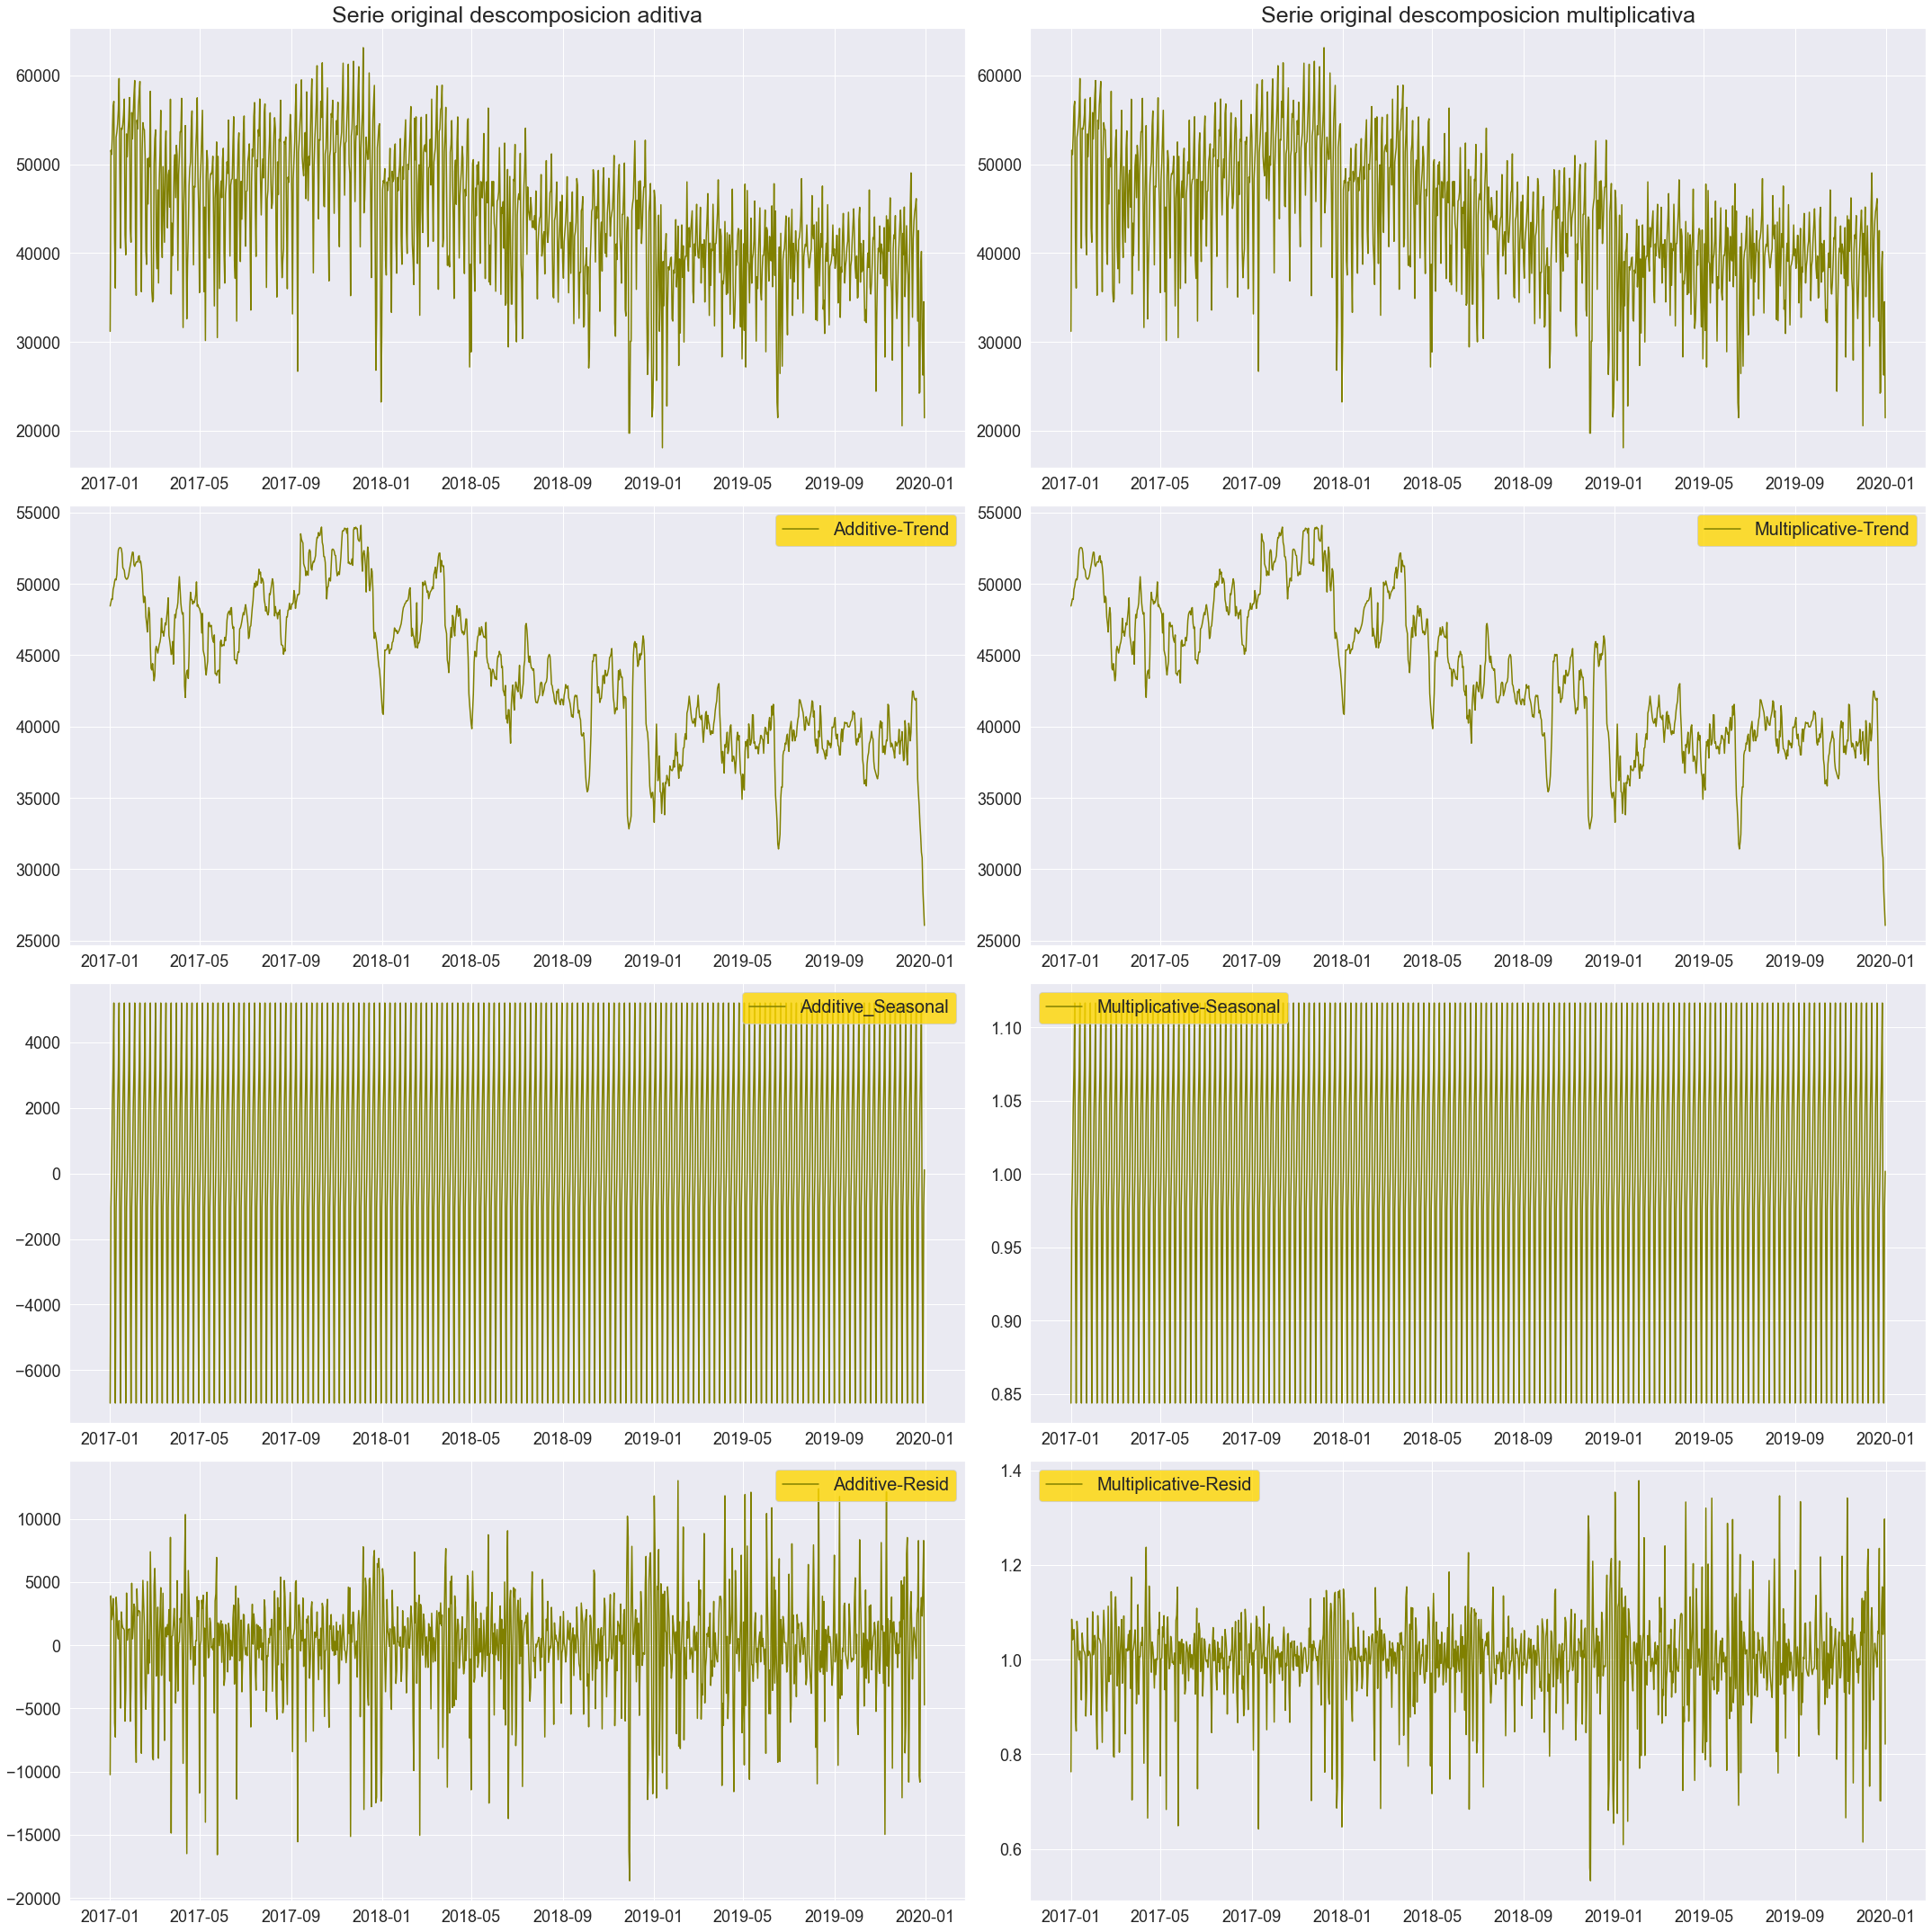

In [69]:
plt.figure(figsize = (30,30))
Gs= gridspec.GridSpec(4,2)

ax0= plt.subplot(Gs[0])
plt.plot(diario, color='olive')
plt.title("Serie original descomposicion aditiva", fontsize= 25)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax1= plt.subplot(Gs[1])
plt.plot(diario, color='olive')
plt.title("Serie original descomposicion multiplicativa",fontsize= 25)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax2= plt.subplot(Gs[2])
plt.plot(result_add.trend, color='olive', label="Additive-Trend")
plt.legend(fontsize=20, facecolor= 'gold')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax3= plt.subplot(Gs[3])
plt.plot(result_mul.trend, color='olive', label='Multiplicative-Trend')
plt.legend(fontsize=20, facecolor= 'gold')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax4= plt.subplot(Gs[4])
plt.plot(result_add.seasonal, color='olive', label='Additive_Seasonal')
plt.legend(fontsize=20, facecolor= 'gold')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)


ax5= plt.subplot(Gs[5])
plt.plot(result_mul.seasonal, color='olive', label='Multiplicative-Seasonal')
plt.legend(fontsize=20, facecolor= 'gold')
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax6= plt.subplot(Gs[6])
plt.plot(result_add.resid, color='olive', label='Additive-Resid')
plt.legend(fontsize=20, facecolor= 'gold', loc= 1)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)

ax7= plt.subplot(Gs[7])
plt.plot(result_mul.resid, color='olive', label='Multiplicative-Resid')
plt.legend(fontsize=20, facecolor= 'gold', loc= 2)
plt.xticks(fontsize= 18)
plt.yticks(fontsize= 18)


plt.tight_layout()
plt.show()

*Al descomponer la Serie con distintos modelos, en si los graficos observados son muy parecidos. Con la diferencia que en el modelo 'Aditivo' los resultantes "residuoss" tienen un comportamiento completamente aleatorio y una media en 0 (cero). Estos indicios indican que estamos ante la presencia de "Ruido blando", al contrario de los "residuos" devueltos con el modelo "Multiplicativo". Una de las formas de describir el Ruido blanco es como una señal aleatoria (proceso estocástico) que se caracteriza por el hecho de que sus valores de señal en dos tiempos diferentes no guardan correlación estadística.*
- Descomposicion Aditiva de la Media Semanal

In [70]:
result = seasonal_decompose(semanal_m.cantidad_pasos, model='additive')

In [71]:
result.trend

fecha
2017-01-01   NaN
2017-01-08   NaN
2017-01-15   NaN
2017-01-22   NaN
2017-01-29   NaN
              ..
2019-12-08   NaN
2019-12-15   NaN
2019-12-22   NaN
2019-12-29   NaN
2020-01-05   NaN
Freq: W-SUN, Name: trend, Length: 158, dtype: float64

In [72]:
result.seasonal

fecha
2017-01-01   -4360.102709
2017-01-08   -5237.804632
2017-01-15   -3970.977023
2017-01-22   -2652.969468
2017-01-29   -2144.821803
                 ...     
2019-12-08    4268.610203
2019-12-15    4009.297703
2019-12-22    1383.071054
2019-12-29   -4360.102709
2020-01-05   -5237.804632
Freq: W-SUN, Name: seasonal, Length: 158, dtype: float64

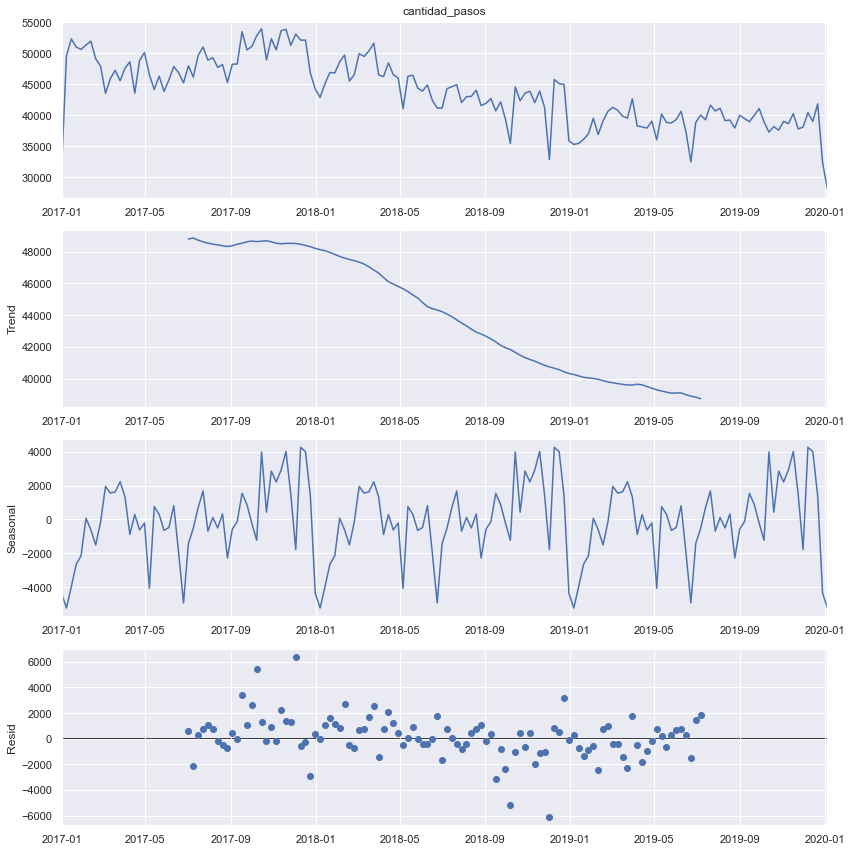

In [73]:
matplotlib.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

El gráfico anterior muestra claramente que la cantidad de pasos es inestable, junto con su evidente estacionalidad, que es anual:

1. En el primer gráfico vemos la serie tal como nos la presentan.
2. Trend: vemos la tendencia de la serie, que ya hemos demostrado que es negativa.
3. Seasonal: vemos la estacionalidad de la serie, que claramente es anual.
4. Resid: vemos los residuas de la serie,se encuentran sin correlacion alguna y el promedio en general se encuentra fijo en 0 (cero), o sea denota Ruido Blanco. *el ruido blanco es completamente aleatorio con una media de 0. En ruido blanco no hay patrón alguno.*

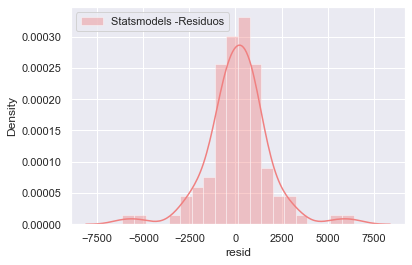

In [74]:
plt.figure(figsize = (6,4))
sns.distplot(result.resid, bins = 20, color='lightcoral', label="Statsmodels -Residuos")

plt.legend()
plt.show()

Observamos que los residuos tienen una distribucion normal.
### Autocorrelacion

In [75]:
nlags =  52*3
autocorr = acf(semanal_m.cantidad_pasos, nlags = nlags)

In [76]:
autocorr.shape

(157,)

Text(0.5, 0, 'lag')

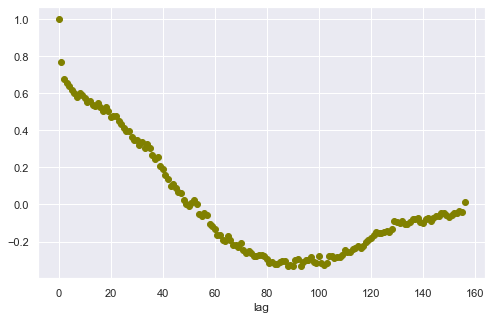

In [77]:
plt.figure(figsize = (8,5))
plt.scatter(np.arange(nlags+1), autocorr,color='olive')
plt.xlabel('lag')

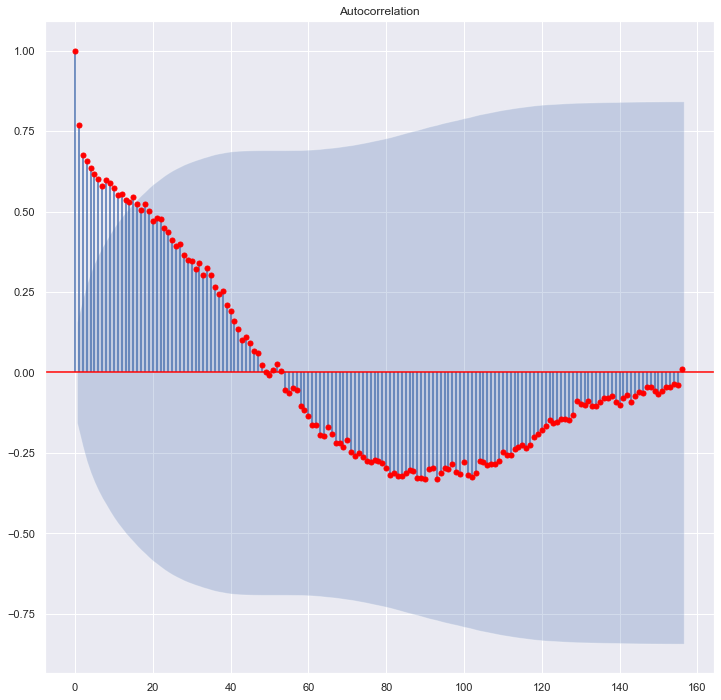

In [78]:
plot_acf(semanal_m.cantidad_pasos, lags = 52*3, color='red')
plt.show()

*La autocorrelación o dependencia secuencial es una herramienta estadística utilizada frecuentemente en el procesado de señales.*

La función de autocorrelación se define como la correlación cruzada de la señal consigo misma. La función de autocorrelación resulta de gran utilidad para encontrar patrones repetitivos dentro de una señal, como la periodicidad de una señal enmascarada bajo el ruido o para identificar la frecuencia fundamental de una señal que no contiene dicha componente, pero aparecen numerosas frecuencias armónicas de esta. Si una serie está significativamente autocorrelacionada, eso significa que los valores anteriores de la serie (rezagos) pueden ser útiles para predecir el valor actual.

## Predicciones a Futuro
### Ultimo Trimestre 2019
**Modelos Benchmark**

*La metrica de Evaluacion elegida es RMSE dado el manejo de los valores atipicos que se ha realizado en el preprocesamiento de datos*

In [79]:
# 3ª trimestre 2019
fecha_i='2019-07-01'
fecha_f='2019-09-30'
X= semanal_m [(semanal_m.index >=fecha_i)&(semanal_m.index <=fecha_f)]

# 4º trimestre 2019 = Ultimo trimestre  2019
fecha_i='2019-10-01'
fecha_f='2019-12-31'
y=semanal_m [(semanal_m.index >=fecha_i)&(semanal_m.index <=fecha_f)]

y_t=X.cantidad_pasos.rolling(window=1, center=True).mean()
b_rmse=np.sqrt(mean_squared_error(y, y_t))

---------------------------------
RMSE en Benchmark: 2999.8287232635116
---------------------------------


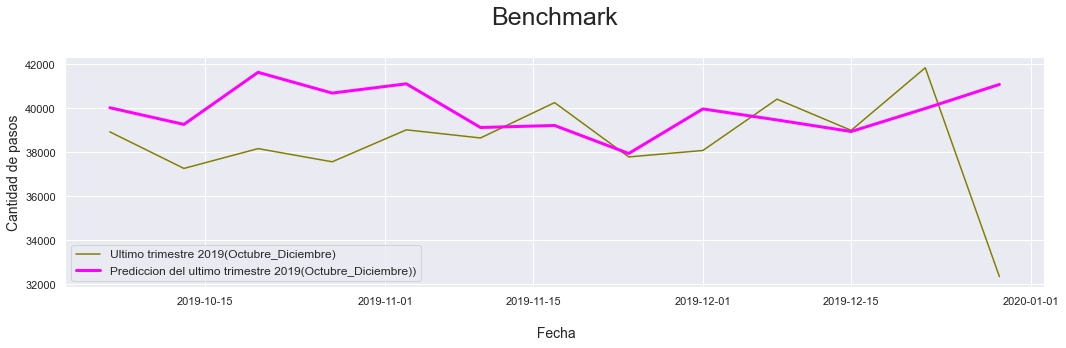

In [80]:
print('---------------------------------')
print(f'RMSE en Benchmark: {b_rmse}')
print('---------------------------------')

plt.figure(figsize=(15,5))
plt.plot(y.index, y.cantidad_pasos,color='olive', label='Ultimo trimestre 2019(Octubre_Diciembre)')
plt.plot(y.index, y_t, lw=3, color='magenta',label='Prediccion del ultimo trimestre 2019(Octubre_Diciembre))')
plt.title ('Benchmark\n', fontsize=25)
plt.xlabel('\n Fecha',fontsize=14)
plt.ylabel('Cantidad de pasos', fontsize=14)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Preparando los datos. Realizamos una máscara para tomar semnas enteras, ya que al hcer un búsqueda por fuera del DS, vemos que la primera y la última son semanas incompletas:

In [81]:
semanal_m=semanal_m[(semanal_m.index >='2017-01-08')&(semanal_m.index <='2019-12-29')]
semanal_m

,cantidad_pasos
fecha,
2017-01-08,49601.714286
2017-01-15,52344.714286
2017-01-22,51030.714286
2017-01-29,50654.428571
2017-02-05,51343.000000
...,...
2019-12-01,38079.285714
2019-12-08,40413.000000
2019-12-15,38994.285714


In [82]:
senial = semanal_m.cantidad_pasos
senial

fecha
2017-01-08    49601.714286
2017-01-15    52344.714286
2017-01-22    51030.714286
2017-01-29    50654.428571
2017-02-05    51343.000000
                  ...     
2019-12-01    38079.285714
2019-12-08    40413.000000
2019-12-15    38994.285714
2019-12-22    41840.142857
2019-12-29    32341.428571
Freq: W-SUN, Name: cantidad_pasos, Length: 156, dtype: float64

In [83]:
senial.shape

(156,)

*Primero definimos cúatos valores hacia atrás tomaremos* (usamos 12 semanas de datos para predecir el valor siguiente).

In [84]:
look_back = 12

In [85]:
N = senial.shape[0]
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(143, 12) (143,)


In [86]:
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [87]:
print(X)

[[49601.71428571 52344.71428571 51030.71428571 ... 45927.71428571
  47256.28571429 45583.28571429]
 [52344.71428571 51030.71428571 50654.42857143 ... 47256.28571429
  45583.28571429 47613.85714286]
 [51030.71428571 50654.42857143 51343.         ... 45583.28571429
  47613.85714286 48639.57142857]
 ...
 [38941.71428571 39989.57142857 41081.14285714 ... 40255.71428571
  37785.71428571 38079.28571429]
 [39989.57142857 41081.14285714 38926.14285714 ... 37785.71428571
  38079.28571429 40413.        ]
 [41081.14285714 38926.14285714 37262.85714286 ... 38079.28571429
  40413.         38994.28571429]]


In [88]:
print(y)

[47613.85714286 48639.57142857 43558.85714286 48889.28571429
 50135.14285714 46553.57142857 44153.14285714 46320.
 43864.85714286 45705.28571429 47878.14285714 46874.57142857
 45235.85714286 47985.71428571 46165.57142857 49681.42857143
 51022.28571429 48891.42857143 49309.14285714 47749.28571429
 48177.57142857 45283.85714286 48237.         48276.14285714
 53502.85714286 50571.28571429 51095.85714286 52845.42857143
 53976.         48938.71428571 52378.57142857 50563.85714286
 53663.42857143 53894.71428571 51293.28571429 53138.57142857
 52141.57142857 52151.85714286 46800.28571429 44241.71428571
 42891.71428571 45111.42857143 46908.42857143 46841.
 48610.71428571 49720.57142857 45533.28571429 46566.57142857
 49966.85714286 49500.85714286 50387.57142857 51637.85714286
 46506.42857143 46246.42857143 48465.         46557.71428571
 46022.         41067.14285714 46302.14285714 46472.
 44387.         43909.85714286 44898.71428571 42404.85714286
 41164.85714286 41151.71428571 44287.42857143 44

Hacemos el train/test split.

In [89]:
N_train = 143 - look_back # cantidad de instancias que vamos a usar para entrenar. look_back = 12 semanas 
N_test = 12  #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(131, 12) (131,)
(12, 12) (12,)


In [90]:
y_test = y[N_train:N_train+N_test]
print(y_test)

[38926.14285714 37262.85714286 38163.85714286 37564.28571429
 39018.42857143 38648.         40255.71428571 37785.71428571
 38079.28571429 40413.         38994.28571429 41840.14285714]


### RandomForestRegressor

In [91]:
rf = RandomForestRegressor( random_state=42, n_jobs = -1)

In [92]:
rf.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [93]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

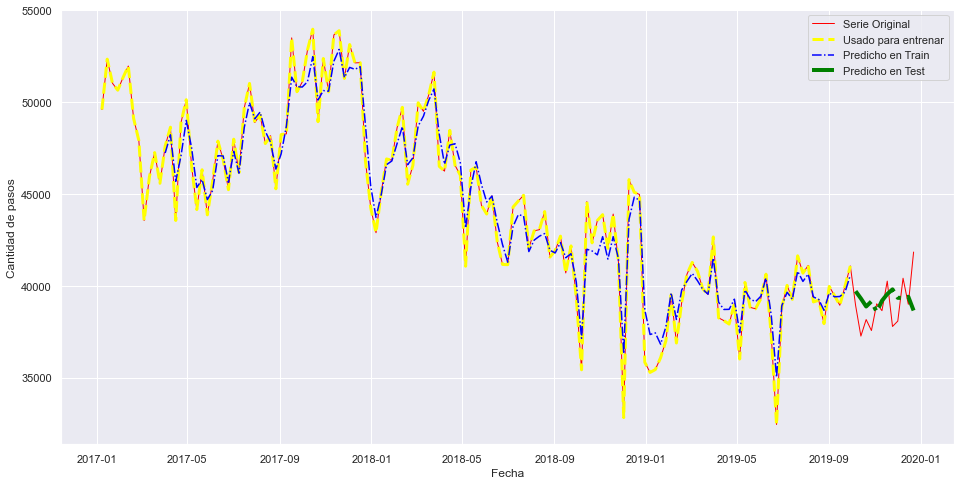

RMSE RFR en Train: 1042.1972621161165
RMSE RFR en Test: 1470.78315746579


In [94]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', lw = 3,color='yellow',label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse =np.sqrt( mean_squared_error(y_train, y_train_pred))
print('RMSE RFR en Train:',rmse)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('RMSE RFR en Test:',rmse)

**Buscando los mejores hiperparámetros**

In [95]:
tss= TimeSeriesSplit(n_splits=2)

In [96]:
param_grid = {'n_estimators':[ 20, 50,100,200],
              'max_depth': [i for i in range(2,20)],
              'max_features': ['auto', 'sqrt', 'log2'], 
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 6]} 
rf_reg=RandomForestRegressor(random_state=42)
rf_gs =GridSearchCV(rf_reg, param_grid, scoring='neg_root_mean_squared_error', cv=tss,verbose=5,n_jobs=-1)

In [97]:
rf_gs.fit(X_train,y_train)

Fitting 2 folds for each of 2592 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | ela

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [98]:
pd.DataFrame(rf_gs.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
735,0.835996,0.039066,0.039064,7.812381e-03,7,auto,2,2,200,"{'max_depth': 7, 'max_features': 'auto', 'min_...",-4302.044641,-2845.932922,-3573.988782,728.055859,1
1455,0.796927,0.046878,0.046880,1.192093e-07,12,auto,2,2,200,"{'max_depth': 12, 'max_features': 'auto', 'min...",-4300.488629,-2848.282807,-3574.385718,726.102911,2
2031,0.822711,0.044511,0.043508,4.499316e-03,16,auto,2,2,200,"{'max_depth': 16, 'max_features': 'auto', 'min...",-4300.488629,-2848.282807,-3574.385718,726.102911,2
1311,0.807203,0.036007,0.034508,5.000830e-04,11,auto,2,2,200,"{'max_depth': 11, 'max_features': 'auto', 'min...",-4300.488629,-2848.282807,-3574.385718,726.102911,2
2319,0.771694,0.015504,0.036510,5.009174e-04,18,auto,2,2,200,"{'max_depth': 18, 'max_features': 'auto', 'min...",-4300.488629,-2848.282807,-3574.385718,726.102911,2


In [99]:
abs(rf_gs.best_score_)

3573.9887817430063

In [100]:
rf_gs.best_params_

{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

**Aplicando los hiperparametros**

In [101]:
rf_h = RandomForestRegressor(max_depth= 7,
                             max_features= 'auto',
                             n_estimators= 200, 
                             random_state=42,
                             min_samples_leaf=2,
                             min_samples_split= 2,
                             n_jobs = -1)

In [102]:
rf_h.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, min_samples_leaf=2, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [103]:
y_train_pred = rf_h.predict(X_train)
y_test_pred = rf_h.predict(X_test)

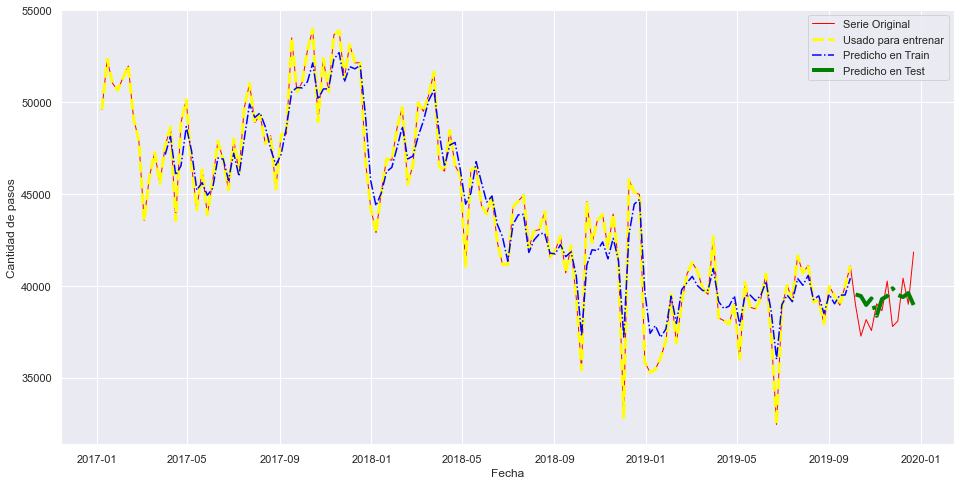

RMSE RFR en Train: 1274.2477878667385
RMSE RFR en Test: 1484.0102828408938


In [104]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', lw = 3,color='yellow',label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('RMSE RFR en Train:',rmse)

rmse =np.sqrt( mean_squared_error(y_test, y_test_pred))
print('RMSE RFR en Test:',rmse)

*Observamos que los hiperparametros elegidos por el GridSearch no reducen el error*

Realizamos una busqueda manual de los hiperparametros.

In [105]:
rf_h_1 = RandomForestRegressor(max_depth=5,
                             max_features= 'auto',
                             n_estimators=200, 
                             random_state=42,
                             min_samples_leaf=2,
                             min_samples_split= 4,
                             n_jobs = -1)

In [106]:
rf_h_1.fit(X_train,y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=200, n_jobs=-1, random_state=42)

In [107]:
y_train_pred = rf_h_1.predict(X_train)
y_test_pred = rf_h_1.predict(X_test)

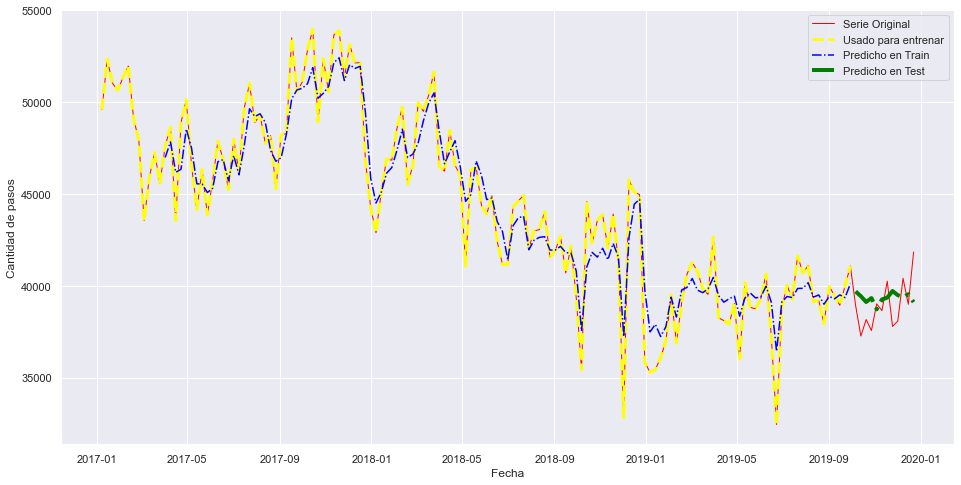

RMSE RFR en Train: 1423.047032097427
RMSE RFR en Test: 1448.605374538309


In [108]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', lw = 3,color='yellow',label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('RMSE RFR en Train:',rmse)

rmse_rf =np.sqrt( mean_squared_error(y_test, y_test_pred))
print('RMSE RFR en Test:',rmse_rf)

*Conclusión RandomForestRegressor*

Se observa una leve mejoria del RMSE en el Test al hacer una busqueda manual de los hiperparámetros. Al comparar con el Benchmarck se observa una reduccion de casi el 50% del RMSE.

**Feature Importance del Modelo**

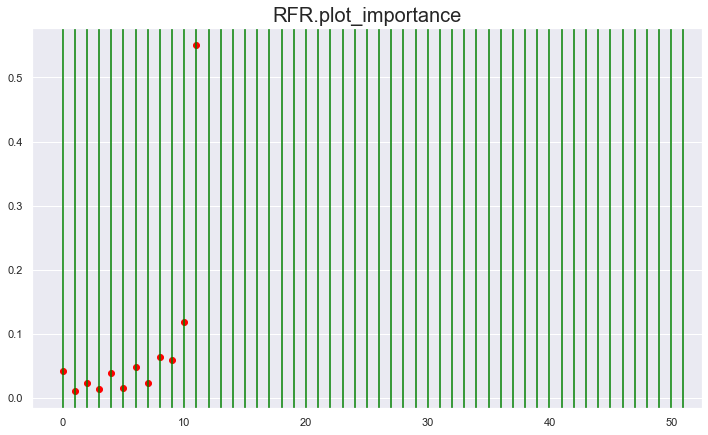

In [109]:
plt.figure(figsize = (12,7))

plt.scatter(np.arange(rf_h_1.feature_importances_.size),rf_h_1.feature_importances_,color='red')
plt . title ( "RFR.plot_importance", size=20 ) 
for x in range(52):
    plt.axvline(x, linestyle ='-', color= 'green')
    
plt.show()

*Si analizamos la importancia de las características que devuelve RFR, vemos que de las 12 semanas usadas para predecir, las dos últimas semanas son las más relevantes*

**XGBoostRegressor**

In [110]:
xgb=XGBRegressor(objective = 'reg:squarederror',random_state=42)

In [111]:
xgb.fit(X_train,y_train)

XGBRegressor(objective='reg:squarederror', random_state=42)

In [112]:
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

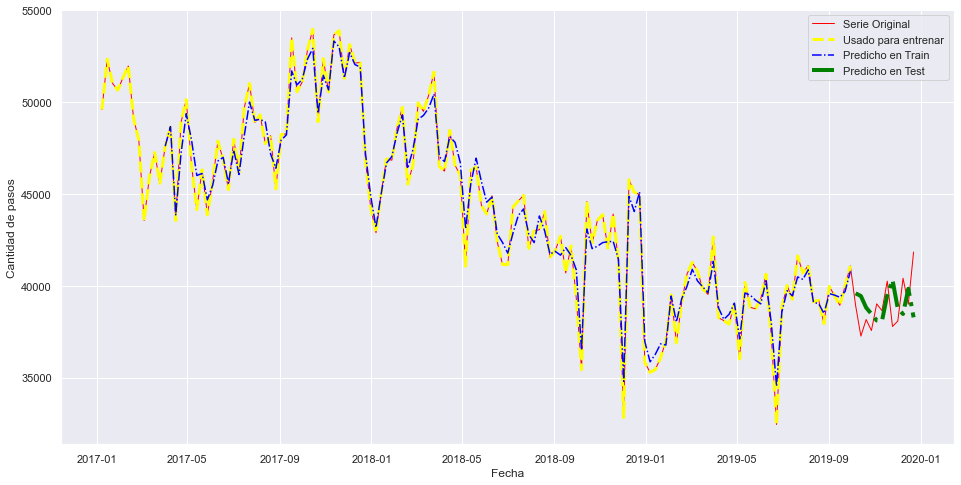

RMSE XGB en Train: 813.9315330707061
RMSE XGB en Test: 1638.0702946070462


In [113]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', lw = 3,color='yellow',label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse =np.sqrt( mean_squared_error(y_train, y_train_pred))
print('RMSE XGB en Train:',rmse)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('RMSE XGB en Test:',rmse)

**Buscando los mejores hiperparametros**

In [114]:
param_grid = {'nthread': [4],
              'objective': ['reg:squarederror'],
              'learning_rate': [0.1,0.2,0.3],
              'max_depth':[4,5,6,7],
              'min_child_weight': [1,2,3,4],
              'subsample':[0.5,0.7,0.8,0.9,1],
              'colsample_bytree':[0.5,0.7,1],
              'reg_lambda':[1,2,3],
              'n_estimators':[20,50,100,200]} 
xgb_reg=XGBRegressor(random_state=42)
xgb_gs=GridSearchCV(xgb_reg, param_grid, scoring='neg_root_mean_squared_error', cv=tss,verbose=5,n_jobs=-1)

In [115]:
xgb_gs.fit(X_train,y_train)

Fitting 2 folds for each of 8640 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1578 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2027 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2454 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2796 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 3174 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 3588 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 4066 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 4636 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 5158 tasks      | e

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             estimator=XGBRegressor(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7],
                         'min_child_weight': [1, 2, 3, 4],
                         'n_estimators': [20, 50, 100, 200], 'nthread': [4],
                         'objective': ['reg:squarederror'],
                         'reg_lambda': [1, 2, 3],
                         'subsample': [0.5, 0.7, 0.8, 0.9, 1]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [116]:
pd.DataFrame(xgb_gs.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_nthread,param_objective,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
7081,0.070317,0.007813,0.000000,0.000000,1,0.2,5,3,20,4,reg:squarederror,1,0.7,"{'colsample_bytree': 1, 'learning_rate': 0.2, ...",-3072.444496,-2709.702809,-2891.073652,181.370843,1
6841,0.078139,0.000006,0.000000,0.000000,1,0.2,4,3,20,4,reg:squarederror,1,0.7,"{'colsample_bytree': 1, 'learning_rate': 0.2, ...",-3080.391789,-2732.334626,-2906.363208,174.028582,2
7561,0.093774,0.015609,0.000000,0.000000,1,0.2,7,3,20,4,reg:squarederror,1,0.7,"{'colsample_bytree': 1, 'learning_rate': 0.2, ...",-3081.928757,-2742.392795,-2912.160776,169.767981,3
8295,0.281269,0.046878,0.007813,0.007813,1,0.3,6,3,50,4,reg:squarederror,1,0.5,"{'colsample_bytree': 1, 'learning_rate': 0.3, ...",-2940.592875,-2883.777252,-2912.185064,28.407811,4
8310,0.664099,0.070330,0.000000,0.000000,1,0.3,6,3,100,4,reg:squarederror,1,0.5,"{'colsample_bytree': 1, 'learning_rate': 0.3, ...",-2953.249041,-2911.804800,-2932.526920,20.722120,5


In [117]:
abs(xgb_gs.best_score_)

2891.0736521634376

In [118]:
xgb_gs.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 20,
 'nthread': 4,
 'objective': 'reg:squarederror',
 'reg_lambda': 1,
 'subsample': 0.7}

**Aplicando los hiperparametros**

In [119]:
xgb_h=XGBRegressor(colsample_bytree=1,
                   learning_rate= 0.2,
                   max_depth= 5,
                   min_child_weight= 3,
                   n_estimators= 20,
                   nthread= 4,
                   objective= 'reg:squarederror',
                   n_jobs = -1,
                   random_state=42,
                   reg_lambda= 1,
                   subsample= 0.7)

In [120]:
xgb_h.fit(X_train,y_train)

XGBRegressor(learning_rate=0.2, max_depth=5, min_child_weight=3,
             n_estimators=20, n_jobs=-1, nthread=4,
             objective='reg:squarederror', random_state=42, subsample=0.7)

In [121]:
y_train_pred = xgb_h.predict(X_train)
y_test_pred = xgb_h.predict(X_test)

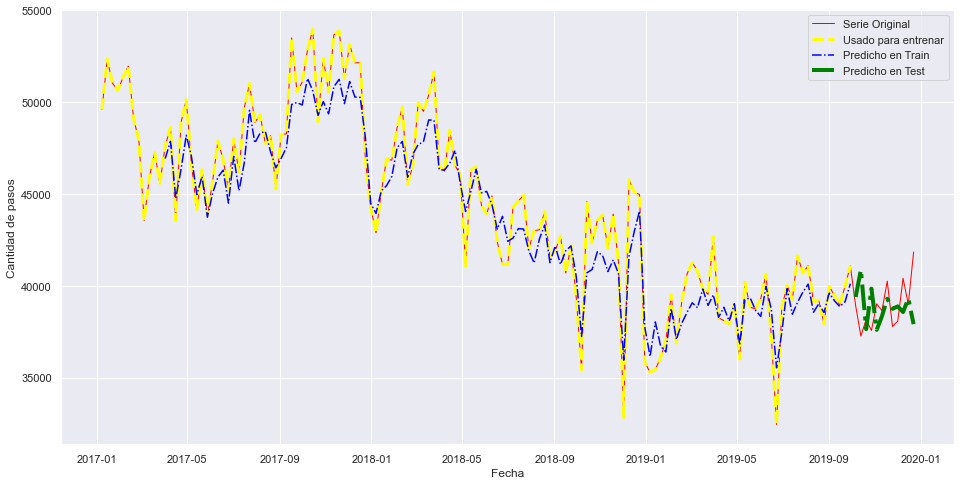

RMSE XGB en Train: 1534.0584211332985
RMSE XGB en Test: 1875.7842218763512


In [122]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', lw = 3,color='yellow',label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('RMSE XGB en Train:',rmse)

rmse =np.sqrt(mean_squared_error(y_test, y_test_pred))
print('RMSE XGB en Test:',rmse)

*Observamos que los hiperparametros elegidos por el GridSearch no reducen el error.*

Realizamos una busqueda manual de los hiperparametros.

In [123]:
xgb_h_1=XGBRegressor(colsample_bytree=1,
                   learning_rate= 0.3,
                   max_depth= 5,
                   min_child_weight= 3,
                   n_estimators= 20,
                   nthread= 4,
                   objective= 'reg:squarederror',
                   n_jobs = -1,
                   random_state=42,
                   reg_lambda= 1,
                   subsample= 0.5)

In [124]:
xgb_h_1.fit(X_train,y_train)

XGBRegressor(learning_rate=0.3, max_depth=5, min_child_weight=3,
             n_estimators=20, n_jobs=-1, nthread=4,
             objective='reg:squarederror', random_state=42, subsample=0.5)

In [125]:
y_train_pred = xgb_h_1.predict(X_train)
y_test_pred = xgb_h_1.predict(X_test)

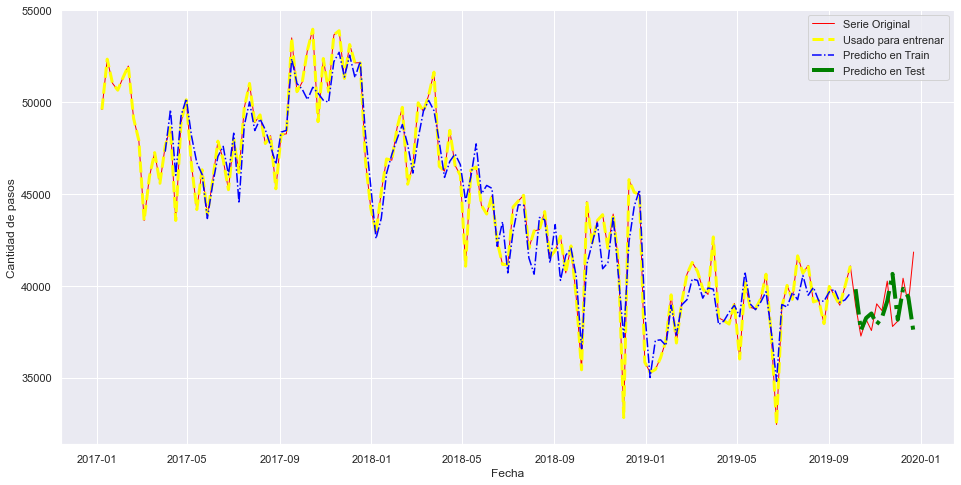

RMSE XGB en Train: 1326.4551836908465
RMSE XGB en Test: 1639.4162286610515


In [126]:
plt.figure(figsize=(16,8))
plt.plot(senial.index[:length_total], senial[:length_total],lw = 1, color='red', label = 'Serie Original')
plt.plot(senial.index[:N_train + look_back], senial[:N_train + look_back],'--', lw = 3,color='yellow',label = 'Usado para entrenar')
plt.plot(senial.index[look_back: look_back + N_train], y_train_pred,'-.',color='blue',label = 'Predicho en Train')
plt.plot(senial.index[N_train+look_back: length_total], y_test_pred,'-.',color='green', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.show()
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print('RMSE XGB en Train:',rmse)

rmse_xgb =np.sqrt( mean_squared_error(y_test, y_test_pred))
print('RMSE XGB en Test:',rmse_xgb)

*Conclusión de XGBoostRegressor*

Se observa una leve mejoria del RMSE en el Test al hacer una busqueda manual de los hiperparámetros. En cuanto si comparamos con el Benchmarck se observa una reduccion de casi el 50% del RMSE.

**Feature Importance del Modelo**

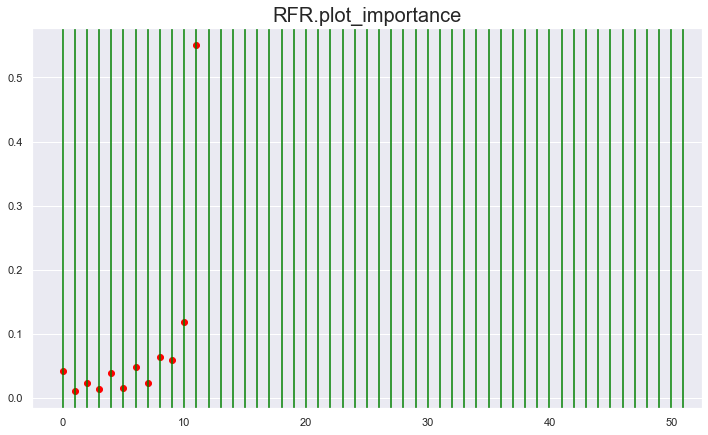

In [127]:
plt.figure(figsize = (12,7))

plt.scatter(np.arange(rf_h_1.feature_importances_.size),rf_h_1.feature_importances_,color='red')
plt . title ( "RFR.plot_importance", size=20 ) 
for x in range(52):
    plt.axvline(x, linestyle ='-', color= 'green')
    
plt.show()

Si analizamos la importancia de las características que devuelve RFR, vemos que de las 12 semanas usadas para predecir, las dos últimas semanas son las más relevantes.

### Arima
Uno de los métodos más comunes utilizados en la predicción de series de tiempo se conoce como el modelo ARIMA, que significa Autoreg Ressive Integrado Moving Average. ARIMA es un modelo que se puede ajustar a datos de series de tiempo para comprender o predecir mejor los puntos futuros de la serie.

Hay tres números enteros distintos ( p, d, q) que se utilizan para parametrizar los modelos ARIMA. Por eso, los modelos ARIMA se denotan con la notación ARIMA(p, d, q). Juntos, estos tres parámetros tienen en cuenta la estacionalidad, la tendencia y el ruido en los conjuntos de datos:

- **p** es la parte auto-regresiva del modelo. Nos permite incorporar el efecto de valores pasados. Ejemplo, Sería como afirmar que es probable que haga calor mañana si ha estado caliente los últimos 3 días.

- **d** es la parte integrada del modelo. Esto incluye términos en el modelo que incorporan la cantidad de diferenciación (es decir, el número de puntos de tiempo pasado para restar del valor actual) para aplicar a la serie de tiempo. Ejemplo,sería similar a afirmar que es probable que mañana tenga la misma temperatura si la diferencia de temperatura en los últimos tres días ha sido muy pequeña.

- **q** es la parte media móvil del modelo. Esto nos permite establecer el error de nuestro modelo como una combinación lineal de los valores de error observados en puntos de tiempo anteriores en el pasado.

Cuando se trata de efectos estacionales, utilizamos el ARIMA estacional , que se denota como ARIMA(p,d,q)(P,D,Q)s. O sea (p, d, q) muestran los parámetros no estacionales descritos anteriormente, aunque (P, D, Q)siguen la misma definición pero se aplican al componente estacional de la serie.

SARIMAX es un método disponible en Python para modelar y predecir puntos futuros de una serie de tiempo. Significa promedios móviles integrados autorregresivos estacionales con regresores exógenos .

In [128]:
warnings.filterwarnings('ignore')

In [129]:
y=semanal_m
y.head

<bound method NDFrame.head of             cantidad_pasos
fecha                     
2017-01-08    49601.714286
2017-01-15    52344.714286
2017-01-22    51030.714286
2017-01-29    50654.428571
2017-02-05    51343.000000
...                    ...
2019-12-01    38079.285714
2019-12-08    40413.000000
2019-12-15    38994.285714
2019-12-22    41840.142857
2019-12-29    32341.428571

[156 rows x 1 columns]>

In [130]:
y['2019':]

,cantidad_pasos
fecha,
2019-01-06,35284.857143
2019-01-13,35439.571429
2019-01-20,36088.142857
2019-01-27,37002.714286
2019-02-03,39509.714286
2019-02-10,36886.285714
2019-02-17,39094.857143
2019-02-24,40634.142857
2019-03-03,41274.142857


- d es el orden de integración no estacional de las series temporales.
- D es el orden de integración de las series de tiempo estacionales.
- p es el orden del componente AR no estacional.
- P es el orden del componente AR no estacional.
- q es el orden del componente MA no estacional.
- Q es el orden del componente MA estacional.
- s es la duración de la estcionalidad

In [131]:
d=range(0,3)
p=q=range(8,13)
pdq=list(itertools.product (p,d,q))
seasonal_pdq=[(x[0],x[1],x[2],12)
              for x in list(itertools.product (p,d,q)) ]
print('Ejemplos de combinaciones de parametros para SARIMAX ....')
print('SARIMAX:{} x{}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX:{} x{}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX:{} x{}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX:{} x{}'.format(pdq[2],seasonal_pdq[4]))

Ejemplos de combinaciones de parametros para SARIMAX ....
SARIMAX:(8, 0, 9) x(8, 0, 9, 12)
SARIMAX:(8, 0, 9) x(8, 0, 10, 12)
SARIMAX:(8, 0, 10) x(8, 0, 11, 12)
SARIMAX:(8, 0, 10) x(8, 0, 12, 12)


**ATENCIÓN: No recomiendamos correr la siguiente celda por su largo tiempo de procesamiento**

In [ ]:
#d=range(0,3)
#p=q=range(8,13)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=sm.tsa.statespace.SARIMAX (y,
                                           order= param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results=mod.fit()
            
            print('SARIMAX{}x{} - AIC:{}'.format(param,param_seasonal, results.aic))
            
        except:
            continue

SARIMAX(8, 0, 8)x(8, 0, 8, 12) - AIC:987.521277351577
SARIMAX(8, 0, 8)x(8, 0, 9, 12) - AIC:767.8374118798665
SARIMAX(8, 0, 8)x(8, 0, 10, 12) - AIC:554.02674087618
SARIMAX(8, 0, 8)x(8, 0, 11, 12) - AIC:340.51110842287596
SARIMAX(8, 0, 8)x(8, 0, 12, 12) - AIC:126.82938849910201
SARIMAX(8, 0, 8)x(8, 1, 8, 12) - AIC:781.3967667699187
SARIMAX(8, 0, 8)x(8, 1, 9, 12) - AIC:560.1165681172007
SARIMAX(8, 0, 8)x(8, 1, 10, 12) - AIC:342.6269242072556
SARIMAX(8, 0, 8)x(8, 1, 11, 12) - AIC:126.43947060388828
SARIMAX(8, 0, 8)x(8, 1, 12, 12) - AIC:74.0
SARIMAX(8, 0, 8)x(8, 2, 8, 12) - AIC:586.4051665740205
SARIMAX(8, 0, 8)x(8, 2, 9, 12) - AIC:356.7139489197809
SARIMAX(8, 0, 8)x(8, 2, 10, 12) - AIC:127.71947104080034
SARIMAX(8, 0, 8)x(8, 2, 11, 12) - AIC:72.0
SARIMAX(8, 0, 8)x(8, 2, 12, 12) - AIC:74.0
SARIMAX(8, 0, 8)x(9, 0, 8, 12) - AIC:789.2768588621917
SARIMAX(8, 0, 8)x(9, 0, 9, 12) - AIC:769.8693505218152
SARIMAX(8, 0, 8)x(9, 0, 10, 12) - AIC:555.029725631491
SARIMAX(8, 0, 8)x(9, 0, 11, 12) - AIC:3

Al evaluar y comparar modelos estadísticos equipados con diferentes parámetros, cada uno puede clasificarse entre sí en función de qué tan bien se ajusta a los datos o su capacidad para predecir con precisión puntos de datos futuros. Usaremos el valor AIC(Criterio de información de Akaike), que se devuelve convenientemente con los modelos ARIMA equipados con statsmodels. Las AIC medidas de la eficacia de un modelo se ajusta a los datos, teniendo en cuenta la complejidad global del modelo. A un modelo que se ajusta muy bien a los datos mientras usa muchas características se le asignará una puntuación AIC mayor que a un modelo que usa menos características para lograr la misma bondad de ajuste. Por lo tanto, nos interesa encontrar el modelo que arroje el AIC valor más bajo.

La calidad relativa de cada modelo es AIC (criterio de información de Akaike), que es un estimador de error de predicción de la muestra; una puntuación AIC más baja indica un modelo más predictivo.

**Despues de dejarlo correr por 12 horass, decidimos detenernos y probar algunas combinaciones manuales. Se deja a modo de constancia, no se vuelve a correr la celda.**

In [132]:
#SARIMAX(10, 1, 8)x(10, 1, 8, 12)
y= semanal_m.cantidad_pasos
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(10, 1, 8),
                                seasonal_order=(10, 1, 8, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4086     17.001     -0.024      0.981     -33.730      32.913
ar.L2         -0.4350     52.529     -0.008      0.993    -103.390     102.520
ar.L3         -0.1900     70.640     -0.003      0.998    -138.642     138.262
ar.L4         -0.3753     19.489     -0.019      0.985     -38.573      37.823
ar.L5          0.3739     52.784      0.007      0.994    -103.080     103.828
ar.L6         -0.3398     44.074     -0.008      0.994     -86.723      86.044
ar.L7         -0.4820     61.749     -0.008      0.994    -121.508     120.544
ar.L8          0.1621    148.870      0.001      0.999    -291.617     291.941
ar.L9          0.4892     77.639      0.006      0.995    -151.681     152.660
ar.L10        -0.2884     37.593     -0.008      0.994     -73.970      73.393
ma.L1         -0.2287     28.407     -0.008      0.9

El resumen atributo que resulta de la salida de SARIMAX devuelve una cantidad significativa de información, pero centraremos nuestra atención en la tabla de coeficientes. La **coef** columna muestra el peso (es decir, la importancia) de cada característica y cómo cada una afecta la serie temporal. La **P>|z|** columna nos informa sobre la importancia de la ponderación de cada característica. Aquí, cada peso tiene un valor p menor o cercano 0.05.

Hemos obtenido un modelo para nuestra serie de tiempo que ahora se puede utilizar para producir pronósticos. Comenzamos comparando los valores predichos con los valores reales de la serie de tiempo, lo que nos ayudará a comprender la precisión de nuestros pronósticos. Los atributos get_prediction() y conf_int() nos permiten obtener los valores e intervalos de confianza asociados para los pronósticos de la serie temporal.

- El dynamic=False argumento asegura que producimos pronósticos con un paso de anticipación, lo que significa que los pronósticos en cada punto se generan utilizando el historial completo hasta ese punto.
- El ultimo trimestre de 2019 es considerado a partir del **6 de Octubre hasta el 29 de Diciembre.**

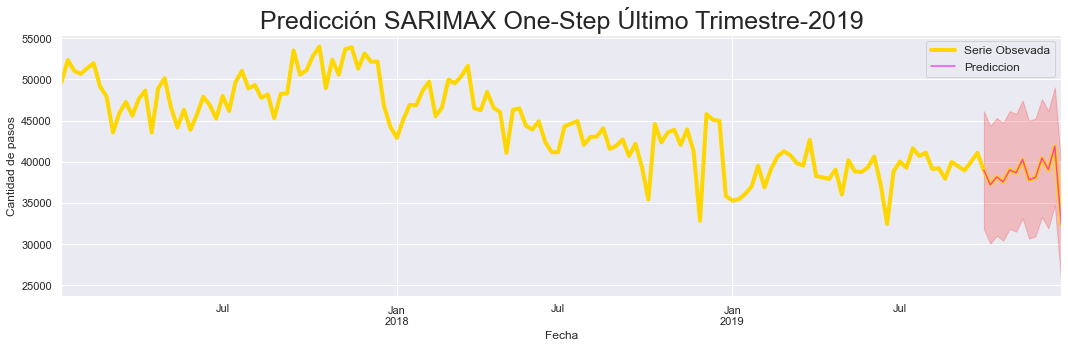

In [133]:
pred = results.get_prediction(start=datetime.datetime(2019,10,6), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='Serie Obsevada',color='gold',lw = 4,figsize=(15,5))

pred.predicted_mean.plot(ax=ax, label='Prediccion', alpha=.7, color='magenta')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.2)
plt.title("Predicción SARIMAX One-Step Último Trimestre-2019", fontsize=25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad de pasos')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Graficamos solamente el año 2019

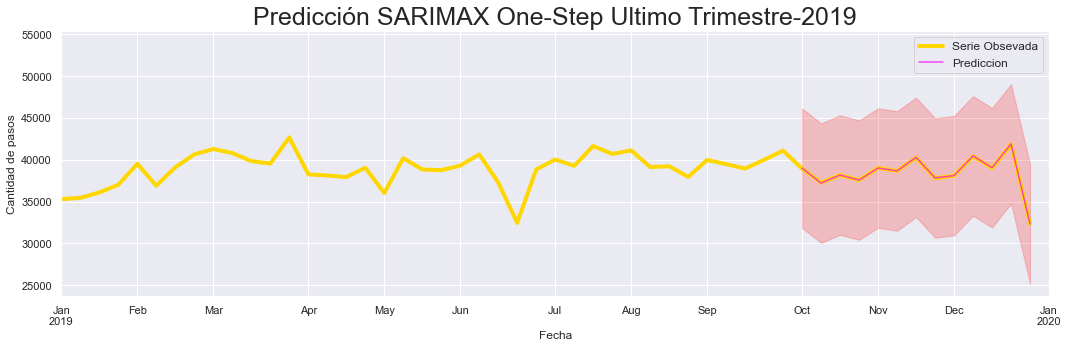

In [134]:
pred = results.get_prediction(start=datetime.datetime(2019,10,6), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='Serie Obsevada',color='gold',lw = 4,figsize=(15,5))

pred.predicted_mean.plot(ax=ax, label='Prediccion', alpha=.7, color='magenta')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title("Predicción SARIMAX One-Step Ultimo Trimestre-2019", fontsize=25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad de pasos')
plt.xlim(datetime.datetime(2019,1,1), datetime.datetime(2019,12,31))
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

En general se alinean muy bien con los valores reales

In [135]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-10-06':]

rmse_so = np.sqrt(mean_squared_error(y_truth,y_forecasted ))
print(f'RMSE de SARIMAX One-Step es: {rmse_so }')

RMSE de SARIMAX One-Step es: 35.04717731285507


Sin embargo, se puede obtener una mejor representación de nuestro verdadero poder predictivo utilizando pronósticos dinámicos. En este caso, solo usamos información de la serie de tiempo hasta cierto punto, y después de eso, los pronósticos se generan usando valores de puntos de tiempo previos previos. (dynamic=True)

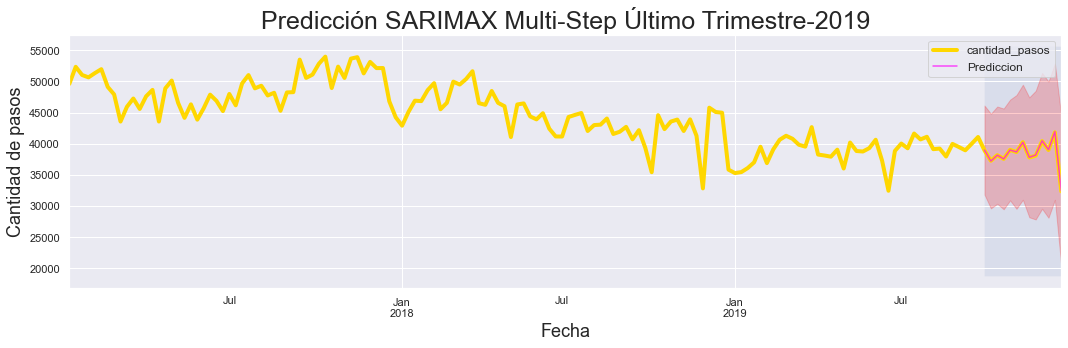

In [136]:
pred_dynamic = results.get_prediction(start=datetime.datetime(2019,10,6), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y['2017':].plot(color='gold',lw = 4, figsize=(15, 5))

pred_dynamic.predicted_mean.plot(ax=ax, label='Prediccion', alpha=.7, figsize=(15, 5), color='magenta')
plt.legend()
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='red', alpha=.2)

ax.fill_betweenx(ax.get_ylim(), datetime.datetime(2019,10,6), y.index[-1],
                 alpha=.1, zorder=-1)
plt.title("Predicción SARIMAX Multi-Step Último Trimestre-2019", fontsize=25)
ax.set_xlabel('Fecha', fontsize=18 )
ax.set_ylabel('Cantidad de pasos', fontsize=18)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

Graficamos solamente el año 2019

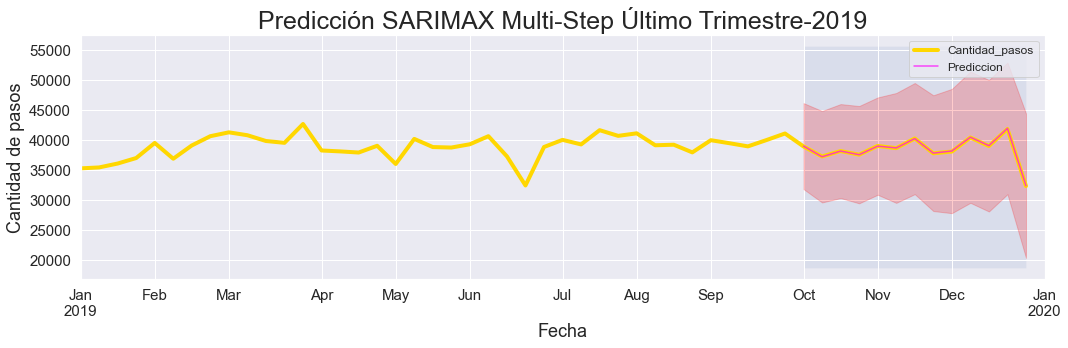

In [137]:
pred_dynamic = results.get_prediction(start=datetime.datetime(2019,10,6), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y['2017':].plot(label='Cantidad_pasos',color='gold',lw = 4,figsize=(15, 5) )

pred_dynamic.predicted_mean.plot(ax=ax, label='Prediccion', alpha=.7, figsize=(15, 5), color='magenta')
plt.legend()
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='red', alpha=.2)

ax.fill_betweenx(ax.get_ylim(), datetime.datetime(2019,10,6), y.index[-1],
                 alpha=.1, zorder=-1)
plt.title("Predicción SARIMAX Multi-Step Último Trimestre-2019", fontsize=25)
ax.set_xlabel('Fecha', fontsize=18 )
ax.set_ylabel('Cantidad de pasos', fontsize=18)
plt.xlim(datetime.datetime(2019,1,1), datetime.datetime(2019,12,31))
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [138]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2019-10-06':]

rmse_sm = np.sqrt(mean_squared_error(y_truth,y_forecasted ))
print(f'RMSE de SARIMAX Multi-Step es: {rmse_sm}')

RMSE de SARIMAX Multi-Step es: 51.06727077839657


- Los valores predichos obtenidos de los pronósticos dinámicos arrojan un RMSE = 51.06727077839657 . Esto es un poco más alto que el de un paso adelante ( One-Step), lo cual es de esperar dado que confiamos en menos datos históricos de la serie de tiempo.

Tanto los pronósticos de un paso adelante como los dinámicos confirman que este modelo de series de tiempo es válido. Sin embargo, gran parte del interés en el pronóstico de series de tiempo es la capacidad de pronosticar valores futuros con mucha anticipación en el tiempo.

#### Comparación de resultados y Conclusión

In [139]:
result_d= {'Modelo':['Bchm','RFR','XGBR','SARIMAX-OS','SARIMAX-MS'],
           'Error':[b_rmse,rmse_rf,rmse_xgb,rmse_so,rmse_sm]}
tabla=pd.DataFrame(result_d,)
tabla

,Modelo,Error
0,Bchm,2999.828723
1,RFR,1448.605375
2,XGBR,1639.416229
3,SARIMAX-OS,35.047177
4,SARIMAX-MS,51.067271


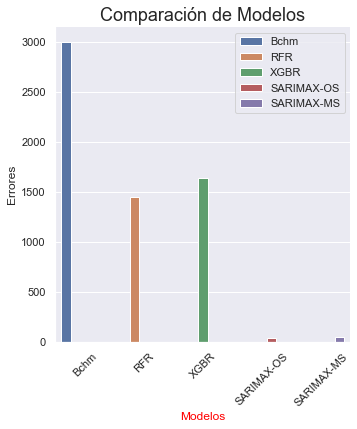

In [140]:
sns.catplot(x='Modelo', y='Error' , hue='Modelo',kind='bar', data=tabla, legend=False)
plt.xlabel('Modelos', color='red')
plt.xticks (rotation =45)
plt.title('Comparación de Modelos', size=18)
plt.ylabel('Errores')

plt.ylim(ymin=0)
plt.legend(loc='best')
plt.show()

Observamos que todos los modelos predicen mejor que el Modelo Benchmark.

La prediccion con SARIMAX tanto One-Step, como Multi-Step es muy buena, los RSME que arroja son excelentes. Por lo tanto SARIMAX One-Step es el modelo elegido para predecir el 2020

## Año 2020
#### Producir y visualizar pronósticos
- Aprovechamos nuestro modelo de serie temporal ARIMA estacional para pronosticar valores futuros. El get_forecast(), atributo de nuestro objeto de serie temporal puede calcular valores pronosticados para un número específico de pasos adelante. Podemos usar la salida de este código para trazar la serie de tiempo y los pronósticos de sus valores futuros.

Graficamos desde el 2017

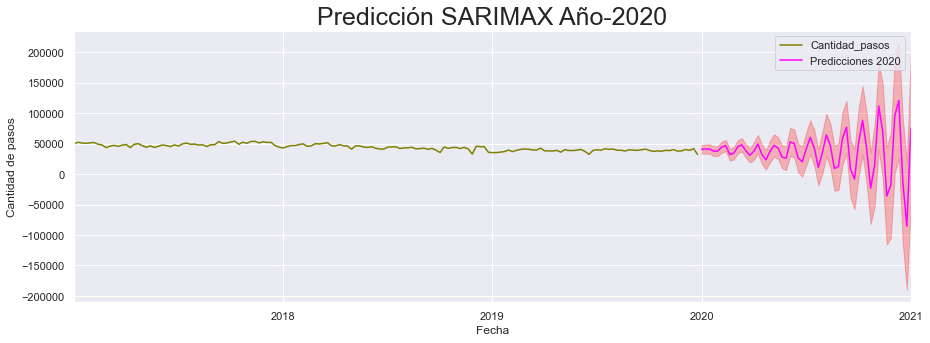

In [141]:
pred_uc = results.get_forecast(steps=datetime.datetime(2020,12,31))
pred_ci = pred_uc.conf_int()

ax = y.plot(label='Cantidad_pasos', color='olive',figsize=(15,5))
pred_uc.predicted_mean.plot(ax=ax, label='Predicciones 2020', color='magenta')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.25)
plt.title("Predicción SARIMAX Año-2020", fontsize=25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad de pasos')

plt.legend()
plt.show()

Graficamos desde el último trimestre del 2019

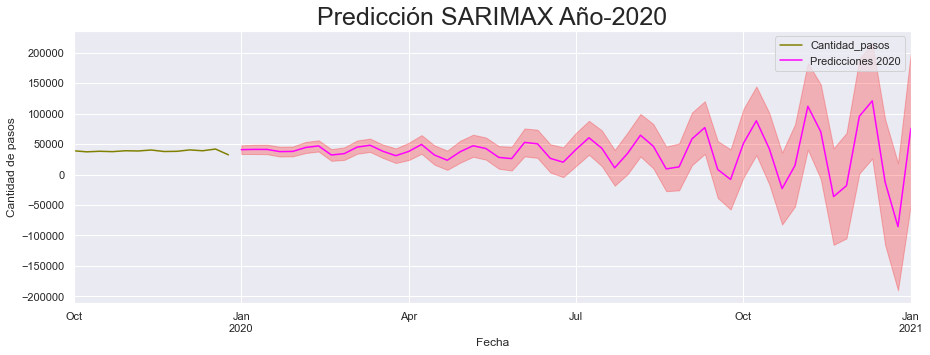

In [142]:
pred_uc = results.get_forecast(steps=datetime.datetime(2020,12,31))
pred_ci = pred_uc.conf_int()

ax = y.plot(label='Cantidad_pasos', color='olive',figsize=(15,5))
pred_uc.predicted_mean.plot(ax=ax, label='Predicciones 2020', color='magenta')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.25)
plt.title("Predicción SARIMAX Año-2020", fontsize=25)
plt.xlim(datetime.datetime(2019,10,6), datetime.datetime(2020,12,31))
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad de pasos')

plt.legend()
plt.show()

Podemos observar que los intervalos de confianza generados por nuestro modelo, que se hacen más grandes a medida que nos adentramos en el futuro. A medida que pronosticamos más en el futuro, es natural que tengamos menos confianza en nuestros valores.

## Conclusiones
Como sabemos las series de tiempo brindan la oportunidad de pronosticar valores futuros, basándose en valores anteriores. Se pueden utilizar para pronosticar tendencias. Asumiendo un supuesto: que el futuro se va a comportar como el pasado. Pero el futuro es incierto y podemos aproximarnos a lo que puede llegar a suceder, pero siempre vamos a tener un componente de sorpresa como esta pandemia.

Este Proyecto fue muy desafiante, requeririó de una búsqueda exhaustiva de documentaciòn extra, ya que contábamos perfectamente con las herramientas, pero no teníamos muy claro cómo implementarlas. Perdimos el medio a buscar y probar como debe hacero un Data Scientist. Los resultados obtenidos son muy buenos, pero hay que tener en cuenta que a veces se pueden mejorar.

En el Proyecto 4 buscaremos implementar un modelo Prophet. Con el objetivo de ver si mejoran las predicciones.